# Predicting Movie Success -- Supervised Learning Capstone

** Teresa O'Neill **
** December, 2017 **

## Background: TMDb Data

[The Movie DataBase (TMDb)] (https://www.themoviedb.org) is a community-built TV and movie database, which has crowd-sourced and curated metadata associated with TV shows and movies since 2008. Its content content is similar to that of the more well-known IMDB, but TMDb offers a public API. The analysis developed here examines production information, cast and crew, popularity, and revenue for 4803 films, based on three sources of data:

1. [TMDb's *movies* dataset from Kaggle] (https://www.kaggle.com/tmdb/tmdb-movie-metadata)
2. TMDb's *credits* dataset from Kaggle
3. [Consumer Price Index for 1914-2017 from the Bureau of Labor Statistics] (https://www.bls.gov/cpi/data.htm)


Two different supervised learning approaches will be used to analyze the movie data. In the first approach, we will predict movie revenue based on factors related to production, cast and crew, and popularity. In the second approach, we will tackle a more novel task: predicting "sleeper hits", defined here as films with low budgets but high profit-to-cost ratios.

By identifying the factors that predict revenue, and predicting the success of a film as measured by revenue, this information could be useful for production companies and directors who make decisions about investing resources in films. In general, the strategy applied to this exercise could be transfered to other domains. Since we anticipate that high-budget 'Blockbuster'-style films will tend to be high-grossing, the second approach--predicting sleeper hits--may offer valuable insight into strategies to maximize return on investment and manage risk in movie productions for which the investment is relatively modest.  

The first approach involves a regression problem, so we will evaluate models including ridge and lasso regression and random forest regression. The second approach consists of a classification problem, which will be handled with logistic regression, k-Nearest Neighbors, Random Forest, SVC, and GBM.

The includes some natural language fields, which will be mapped to binarized vectors, so models that can handle a large feature space and sparce matrices will probably perform best. We will embed feature selection in our models wherever possible, to reduce the effect of random noise. 

In [1]:
#Basic
import pandas as pd
import json
import numpy as np

#Math
import math
import statsmodels.api as sm
from math import sqrt
from collections import Counter

#Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

#Modeling
import sklearn
from sklearn import preprocessing, linear_model, neighbors, tree, ensemble
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.svm import SVC, LinearSVC

#Validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#Model evaluation
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score, make_scorer


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data import and parsing

The two TBDb datasets from Kaggle are available in csv format, including both tabular and JSON fields. 

In [2]:
#Define a function to read in the data
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [3]:
movies = load_tmdb_movies('/Users/teresaoneill/Dropbox/Thinkful/Datasets/tmdb_5000_movies.csv')
credits = load_tmdb_credits('/Users/teresaoneill/Dropbox/Thinkful/Datasets/tmdb_5000_credits.csv')

### Movies dataset

In [4]:
print(movies.shape)
list(movies.columns)

(4803, 20)


['budget',
 'genres',
 'homepage',
 'id',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count']

In [5]:
movies.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{'name': 'Ingenious Film Partners', 'id': 289...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,2787965087,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://disney.go.com/disneypictures/pirates/,285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2007-05-19,961000000,169.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{'name': 'Columbia Pictures', 'id': 5}, {'nam...","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'...",2015-10-26,880674609,148.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,A Plan No One Escapes,Spectre,6.3,4466


The *movies* file includes 20 features and 4803 rows, each pertaining to an individual movie. Several of the columns are stored in JSON format, with nested information encoded as a list of dictionaries. The JSON columns are:

- genres
- keywords
- production companies
- production countries
- spoken languages

The analysis will begin with a simple model, setting aside the more complex natural language fields: at this stage, the *keywords* field is excluded. To reshape the data for analysis, the values will be extracted from the relevant dictionary entries.  

In [6]:
#Identify the relevant JSON fields
dict_fields = movies[['genres', 'production_companies', 'spoken_languages','production_countries']]

In [7]:
#Parse out the JSON fields
def mapper (field, key):
    vals_list = []
    for d in field:
        vals_list.append(d.get(key))
    return vals_list

list_fields = pd.DataFrame()
for col in dict_fields.columns:
    list_fields[col] = dict_fields[col].apply(lambda x: mapper(x, 'name'))

In [8]:
list_fields.head()

,genres,production_companies,spoken_languages,production_countries
0,"[Action, Adventure, Fantasy, Science Fiction]","[Ingenious Film Partners, Twentieth Century Fo...","[English, Español]","[United States of America, United Kingdom]"
1,"[Adventure, Fantasy, Action]","[Walt Disney Pictures, Jerry Bruckheimer Films...",[English],[United States of America]
2,"[Action, Adventure, Crime]","[Columbia Pictures, Danjaq, B24]","[Français, English, Español, Italiano, Deutsch]","[United Kingdom, United States of America]"
3,"[Action, Crime, Drama, Thriller]","[Legendary Pictures, Warner Bros., DC Entertai...",[English],[United States of America]
4,"[Action, Adventure, Science Fiction]",[Walt Disney Pictures],[English],[United States of America]


Let's summarize the frequency of each category extracted from the JSON fields.

In [9]:
#Count values
genres = sum(list_fields['genres'], [])
Counter(genres)

Counter({'Action': 1154,
         'Adventure': 790,
         'Animation': 234,
         'Comedy': 1722,
         'Crime': 696,
         'Documentary': 110,
         'Drama': 2297,
         'Family': 513,
         'Fantasy': 424,
         'Foreign': 34,
         'History': 197,
         'Horror': 519,
         'Music': 185,
         'Mystery': 348,
         'Romance': 894,
         'Science Fiction': 535,
         'TV Movie': 8,
         'Thriller': 1274,
         'War': 144,
         'Western': 82})

In [10]:
production_companies = sum(list_fields['production_companies'], [])
Counter(production_companies)

Counter({'Ingenious Film Partners': 29,
         'Twentieth Century Fox Film Corporation': 222,
         'Dune Entertainment': 59,
         'Lightstorm Entertainment': 5,
         'Walt Disney Pictures': 114,
         'Jerry Bruckheimer Films': 21,
         'Second Mate Productions': 2,
         'Columbia Pictures': 201,
         'Danjaq': 8,
         'B24': 1,
         'Legendary Pictures': 34,
         'Warner Bros.': 319,
         'DC Entertainment': 12,
         'Syncopy': 8,
         'Laura Ziskin Productions': 5,
         'Marvel Enterprises': 16,
         'Walt Disney Animation Studios': 8,
         'Marvel Studios': 13,
         'Prime Focus': 1,
         'Revolution Sun Studios': 16,
         'Heyday Films': 10,
         'DC Comics': 15,
         'Atlas Entertainment': 13,
         'Cruel & Unusual Films': 1,
         'RatPac-Dune Entertainment': 12,
         'Bad Hat Harry Productions': 12,
         'Eon Productions': 22,
         'Infinitum Nihil': 4,
         'Silver Bullet

In [11]:
spoken_languages = sum(list_fields['spoken_languages'], [])
Counter(spoken_languages)

Counter({'': 54,
         '??????': 1,
         'Afrikaans': 7,
         'Bahasa indonesia': 2,
         'Bamanankan': 1,
         'Bosanski': 2,
         'Català': 1,
         'Cymraeg': 2,
         'Dansk': 14,
         'Deutsch': 262,
         'Eesti': 2,
         'English': 4485,
         'Español': 351,
         'Esperanto': 2,
         'Français': 437,
         'Gaeilge': 6,
         'Galego': 1,
         'Hrvatski': 4,
         'Italiano': 188,
         'Kiswahili': 8,
         'Latin': 52,
         'Magyar': 42,
         'Nederlands': 10,
         'No Language': 2,
         'Norsk': 13,
         'Polski': 53,
         'Português': 68,
         'Pусский': 185,
         'Română': 13,
         'Slovenčina': 2,
         'Slovenščina': 1,
         'Somali': 3,
         'Srpski': 6,
         'Tiếng Việt': 17,
         'Türkçe': 18,
         'Wolof': 1,
         'isiZulu': 4,
         'shqip': 4,
         'suomi': 3,
         'svenska': 22,
         'Íslenska': 5,
         'Český': 38

In [12]:
production_countries = sum(list_fields['production_countries'], [])
Counter(production_countries)

Counter({'Afghanistan': 1,
         'Algeria': 1,
         'Angola': 1,
         'Argentina': 9,
         'Aruba': 1,
         'Australia': 110,
         'Austria': 6,
         'Bahamas': 4,
         'Belgium': 25,
         'Bhutan': 1,
         'Bolivia': 1,
         'Bosnia and Herzegovina': 1,
         'Brazil': 13,
         'Bulgaria': 4,
         'Cambodia': 1,
         'Cameroon': 1,
         'Canada': 261,
         'Chile': 2,
         'China': 59,
         'Colombia': 2,
         'Cyprus': 1,
         'Czech Republic': 24,
         'Denmark': 20,
         'Dominica': 1,
         'Dominican Republic': 1,
         'Ecuador': 1,
         'Egypt': 1,
         'Fiji': 1,
         'Finland': 5,
         'France': 306,
         'Germany': 324,
         'Greece': 3,
         'Guadaloupe': 1,
         'Guyana': 1,
         'Hong Kong': 48,
         'Hungary': 13,
         'Iceland': 6,
         'India': 54,
         'Indonesia': 1,
         'Iran': 4,
         'Ireland': 37,
         'I

Several of the categories occur only rarely. In mapping the categories to individual binarized categorical features, we will exclude categories occurring 10 times of less, to keep the feature space from becoming too unwieldy and sparse. 

In [13]:
#Get dummies from lists of categories.
result = pd.DataFrame()
for col in list_fields.columns:
    dummies = list_fields[col].str.join('|').str.get_dummies()
    dummies.drop([col for col, val in dummies.sum().iteritems() if val < 11], axis=1, inplace=True)
    result = pd.concat([dummies, result], axis=1)

In [14]:
#Concatenate dummies with original df, drop unusable columns.
movies_all = pd.concat([movies, result], axis=1)
movies_all = movies_all.drop(['genres', 'spoken_languages','overview','original_title','homepage','tagline','keywords', 'production_companies', 'production_countries','spoken_languages'],1)
movies_all.head(3)

,budget,id,original_language,popularity,release_date,revenue,runtime,status,title,vote_average,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
0,237000000,19995,en,150.437577,2009-12-10,2787965087,162.0,Released,Avatar,7.2,...,0,0,0,0,0,0,1,0,0,0
1,300000000,285,en,139.082615,2007-05-19,961000000,169.0,Released,Pirates of the Caribbean: At World's End,6.9,...,0,0,0,0,0,0,0,0,0,0
2,245000000,206647,en,107.376788,2015-10-26,880674609,148.0,Released,Spectre,6.3,...,0,0,0,0,0,0,0,0,0,0


### Credits dataset

In [15]:
print(credits.shape)
list(credits.columns)

(4803, 4)


['movie_id', 'title', 'cast', 'crew']

In [16]:
credits.head(3)

,movie_id,title,cast,crew
0,19995,Avatar,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de..."
1,285,Pirates of the Caribbean: At World's End,"[{'cast_id': 4, 'character': 'Captain Jack Spa...","[{'credit_id': '52fe4232c3a36847f800b579', 'de..."
2,206647,Spectre,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '54805967c3a36829b5002c41', 'de..."


The *movies* file includes 4 features and 4803 rows. The cast and crew columns consist of long lists of dictionaries, where each dictionary provides information about an individual involved in the production of the film. For this analysis, we will extract a small subset of this information: the names and genders of the two lead actors. The results will be added to the movies database.

In [17]:
def safe_access(container, i, key):
    try:
        return container[i].get(key)
    except IndexError or KeyError:
        return pd.np.nan

In [18]:
movies_all['gender_of_lead'] = credits.cast.apply(safe_access, args=(0, 'gender'))
movies_all['lead'] = credits.cast.apply(safe_access, args=(0, 'name'))
movies_all['gender_of_lead2'] = credits.cast.apply(safe_access, args=(1, 'gender'))
movies_all['lead2'] = credits.cast.apply(safe_access, args=(1, 'name'))

In [19]:
#Fill NaN with 0
values = {'gender_of_lead': 0, 'gender_of_lead2': 0}
movies_all = movies_all.fillna(value=values);

### Consumer Price Index dataset

Next, we add the CPI data provided by the Bureau of Labor Statistics to the dataframe, which we will later use to adjust the budget and revenue data for inflation. The release year of each movie is extracted, and the movies dataframe is merged with the CPI data on year.

In [20]:
#Extract year, month, day from release date.
movies_all['release_date'] = pd.to_datetime(movies_all['release_date'])
movies_all['year'], movies_all['month'] = movies_all['release_date'].dt.year, movies_all['release_date'].dt.month
movies_all = movies_all.drop(['release_date'], 1)

In [21]:
CPI = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/CPI.csv')
CPI['year'] = pd.to_numeric(CPI['year'], errors='coerce')

movies_all = pd.merge(movies_all, CPI, on='year', how='inner')
movies_all.head()

,budget,id,original_language,popularity,revenue,runtime,status,title,vote_average,vote_count,...,Western,gender_of_lead,lead,gender_of_lead2,lead2,year,month,Annual Average,Annual Percent Change,CPI
0,237000000,19995,en,150.437577,2787965087,162.0,Released,Avatar,7.2,11800,...,0,2.0,Sam Worthington,1.0,Zoe Saldana,2009.0,12.0,214.5,-0.40%,1.140793
1,250000000,767,en,98.885637,933959197,153.0,Released,Harry Potter and the Half-Blood Prince,7.4,5293,...,0,2.0,Daniel Radcliffe,2.0,Rupert Grint,2009.0,7.0,214.5,-0.40%,1.140793
2,150000000,8373,en,21.939663,836297228,150.0,Released,Transformers: Revenge of the Fallen,6.0,3138,...,0,2.0,Shia LaBeouf,1.0,Megan Fox,2009.0,6.0,214.5,-0.40%,1.140793
3,200000000,534,en,71.862892,371353001,115.0,Released,Terminator Salvation,5.9,2463,...,0,2.0,Christian Bale,2.0,Sam Worthington,2009.0,5.0,214.5,-0.40%,1.140793
4,200000000,14161,en,45.274225,769653595,158.0,Released,2012,5.6,4903,...,0,2.0,John Cusack,1.0,Amanda Peet,2009.0,10.0,214.5,-0.40%,1.140793


## Data exploration and cleaning

### Categorical features

The data cleaning process will begin with the categorical features. The Production Companies field includes many possible duplicate entries. After dummy-encoding, we are left with a smaller set of categories, which nevertheless contain some redundant values.

In [22]:
for col in movies_all.loc[:, '1492 Pictures':'Worldview Entertainment']:
    print(col, movies_all[col].sum())

1492 Pictures 15
21 Laps Entertainment 7
2929 Productions 12
3 Arts Entertainment 6
40 Acres & A Mule Filmworks 18
Alcon Entertainment 16
Alliance Atlantis Communications 11
Alliance Films 12
Amblin Entertainment 44
American Zoetrope 14
Anonymous Content 13
Apatow Productions 17
Atlas Entertainment 9
BBC Films 32
Bad Hat Harry Productions 8
BenderSpink 8
Big Screen Productions 8
Blumhouse Productions 6
British Broadcasting Corporation (BBC) 11
CBS Films 7
Canal+ 61
Castle Rock Entertainment 38
Centre National de la Cinématographie (CNC) 11
Channel Four Films 13
Cinergi Pictures Entertainment 12
Ciné+ 4
Columbia Pictures 171
Columbia Pictures Corporation 96
Constantin Film Produktion 19
Cruise/Wagner Productions 14
DC Comics 10
DC Entertainment 7
Dark Castle Entertainment 14
Davis Entertainment 30
Davis-Films 11
Dentsu 7
Destination Films 12
Di Bonaventura Pictures 13
DiNovi Pictures 11
Dimension Films 52
Dino De Laurentiis Company 15
Donners' Company 11
Double Feature Films 9
DreamWork

In [23]:
def consolidate_companies(df, name1, name2):
    df[name1] = df.apply(lambda row: row[name2] if row[name1] == 0 else row[name1], axis=1)
    df.drop([name2], 1, inplace=True)
    return df

In [24]:
consolidate_companies(movies_all, 'Columbia Pictures', 'Columbia Pictures Corporation')
consolidate_companies(movies_all, 'DreamWorks Animation', 'DreamWorks SKG')
consolidate_companies(movies_all, 'Dune Entertainment', 'Dune Entertainment III')
consolidate_companies(movies_all, 'Studio Canal', 'StudioCanal')
consolidate_companies(movies_all, 'BBC Films', 'British Broadcasting Corporation (BBC)')
consolidate_companies(movies_all, 'DC Comics', 'DC Entertainment');
consolidate_companies(movies_all, 'Fox 2000 Pictures', 'Fox Searchlight Pictures');
consolidate_companies(movies_all, 'Lions Gate Films', 'Lionsgate');
consolidate_companies(movies_all, 'Marvel Enterprises', 'Marvel Studios');
consolidate_companies(movies_all, 'Miramax', 'Miramax Films');
consolidate_companies(movies_all, 'Paramount Pictures', 'Paramount Vantage');
consolidate_companies(movies_all, 'Fox 2000 Pictures', 'Twentieth Century Fox Film Corporation');
;

''

Since the analysis will address revenue, movies that have not yet been released will be excluded.

In [25]:
movies_all['status'].value_counts()

Released           4011
Rumored               5
Post Production       1
Name: status, dtype: int64

In [26]:
#Drop films that have not been released.
movies_all = movies_all[movies_all['status']=='Released']
movies_all = movies_all.drop(['status'], 1)

In [27]:
#Code months as categorical.
month = {'month': {1:'Jan', 
                    2:'Feb', 
                    3:'Mar', 
                    4:'Apr', 
                    5:'May', 
                    6:'Jun', 
                    7:'Jul', 
                    8:'Aug', 
                    9:'Sep', 
                    10:'Oct', 
                    11:'Nov', 
                    12:'Dec'}}
movies_all.replace(month, inplace=True)

### Numerical features

First, let's explore the distribution of the numerical features. 

In [28]:
movies_continuous = movies_all[['revenue','budget','popularity','runtime','vote_average','vote_count', 'year']]

In [29]:
for col in movies_continuous:
    print(movies_continuous[col].describe())

count    4.011000e+03
mean     7.736944e+07
std      1.515454e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.920493e+07
75%      8.949008e+07
max      2.787965e+09
Name: revenue, dtype: float64
count    4.011000e+03
mean     2.803522e+07
std      3.814837e+07
min      0.000000e+00
25%      9.500000e+05
50%      1.500000e+07
75%      4.000000e+07
max      3.800000e+08
Name: budget, dtype: float64
count    4011.000000
mean       18.922032
std        21.127250
min         0.000000
25%         4.821100
50%        12.362876
75%        25.429415
max       271.972889
Name: popularity, dtype: float64
count    4011.000000
mean      107.363251
std        22.609168
min         0.000000
25%        94.000000
50%       104.000000
75%       118.000000
max       338.000000
Name: runtime, dtype: float64
count    4011.000000
mean        6.151035
std         1.090904
min         0.000000
25%         5.600000
50%         6.300000
75%         6.800000
max        10.000000
Name: vote_average, dt

Both budget and revenue include some 0 entries. Let's take a closer look at these anomalous values for revenue. A quick web search indicates that these zero entries are not accurate--these films did in fact earn money--so the zero entries will be dropped.

In [30]:
#Check for missing or 0 values in the revenue field.
no_revenue = movies_all[movies_all['revenue']==0]
no_revenue.head()

,budget,id,original_language,popularity,revenue,runtime,title,vote_average,vote_count,Australia,...,Western,gender_of_lead,lead,gender_of_lead2,lead2,year,month,Annual Average,Annual Percent Change,CPI
36,60000000,13576,en,15.798622,0,111.0,This Is It,6.7,247,0,...,0,2.0,Michael Jackson,1.0,Orianthi,2009.0,Oct,214.5,-0.40%,1.140793
45,55000000,19724,en,12.340384,0,107.0,Imagine That,5.7,134,0,...,0,2.0,Eddie Murphy,2.0,Thomas Haden Church,2009.0,Jun,214.5,-0.40%,1.140793
56,42000000,18480,en,16.122168,0,83.0,Brüno,5.4,518,0,...,0,2.0,Sacha Baron Cohen,0.0,Richard Bey,2009.0,Jul,214.5,-0.40%,1.140793
76,0,310706,en,0.126738,0,100.0,Black Water Transit,0.0,0,0,...,0,2.0,Laurence Fishburne,2.0,Karl Urban,2009.0,May,214.5,-0.40%,1.140793
83,26000000,37707,en,23.227877,0,104.0,Splice,5.5,671,0,...,0,2.0,Adrien Brody,1.0,Sarah Polley,2009.0,Oct,214.5,-0.40%,1.140793


In [31]:
#Drop 0 values.
movies_all = movies_all[movies_all['revenue']>0]
movies_all = movies_all[movies_all['budget']>0]
movies_all = movies_all[movies_all['runtime']>0]

Both budget and revenue include additional anomalous values: some implausibly low amounts. A quick web search indicates that these values represent dollars in millions, so they are adjusted accordingly. 

In [32]:
#Check for anomalous values.
print(movies_all[movies_all['budget']<100])

      budget     id original_language  popularity  revenue  runtime  \
188        7  38415                en    0.050456        7     82.0   
2166      25  10397                en    4.887940       13    145.0   
2332       8  11980                en   11.818333       16     98.0   
2586      28   1613                en    9.670031       14     93.0   
3094      30  16340                it    4.590277      103     78.0   
3517       7  13006                en    4.857028        5     90.0   
3620      11  28932                en    3.375208       11    145.0   
3959       4  22649                en    1.199451       25     89.0   
3997       1   3082                en   28.276480  8500000     87.0   

                            title  vote_average  vote_count  Australia  \
188                  Bran Nue Dae           5.2           6          0   
2166               Angela's Ashes           7.0          59          0   
2332                 The Prophecy           6.4         138        

In [33]:
#Check for anomalous values.
print(movies_all[movies_all['revenue']<100])

        budget      id original_language  popularity  revenue  runtime  \
188          7   38415                en    0.050456        7     82.0   
329    9000000    2196                en   20.410354       46     90.0   
1974  23000000   14844                en    3.362045       12    111.0   
2016  16000000   18475                en    0.830596       12     97.0   
2166        25   10397                en    4.887940       13    145.0   
2244   2000000  108346                en    0.116150        7     92.0   
2332         8   11980                en   11.818333       16     98.0   
2445  12000000   10944                en   10.536092       23    119.0   
2586        28    1613                en    9.670031       14     93.0   
3517         7   13006                en    4.857028        5     90.0   
3620        11   28932                en    3.375208       11    145.0   
3959         4   22649                en    1.199451       25     89.0   

                        title  vote_a

In [34]:
#Correct the anomalous values based on the assumption that they represent millions.
movies_all['budget'] = movies_all['budget'].apply(lambda x: x*1000000 if x<100 else x)
movies_all['revenue'] = movies_all['revenue'].apply(lambda x: x*1000000 if x<100 else x)

Now that we have removed and adjusted anomalous values, let's adjust budget and revenue for inflation using the CPI for the release year.

In [35]:
#Adjust for inflation
movies_all['budget_adj'] = movies_all['budget'] * movies_all['CPI']
movies_all['revenue_adj'] = movies_all['revenue'] * movies_all['CPI']
movies_all = movies_all.drop(['Annual Average','Annual Percent Change','CPI'], 1)

### Outlier analysis

Both budget and revenue (now adjusted for inflation) have extremely right-skewed distributions, which may pose a problem for the regression models.

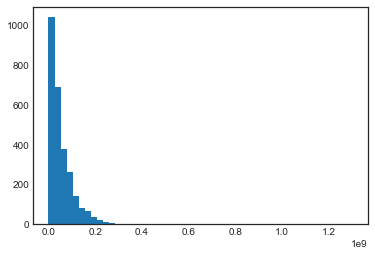

count    2.748000e+03
mean     5.316289e+07
std      5.607152e+07
min      2.899163e+02
25%      1.700014e+07
50%      3.701117e+07
75%      7.415152e+07
max      1.302535e+09
Name: budget_adj, dtype: float64

In [36]:
plt.hist(movies_all['budget_adj'], bins=50)
plt.show()

movies_all['budget_adj'].describe()

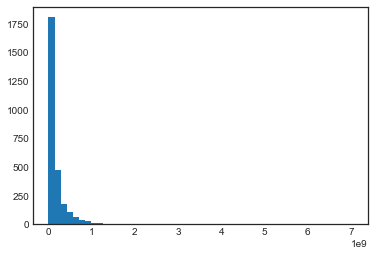

count    2.748000e+03
mean     1.719135e+08
std      3.006680e+08
min      1.463653e+02
25%      2.609298e+07
50%      7.997818e+07
75%      1.989744e+08
max      7.044833e+09
Name: revenue_adj, dtype: float64

In [37]:
plt.hist(movies_all['revenue_adj'], bins=50)
plt.show()
movies_all['revenue_adj'].describe()

In [38]:
movies_all.loc[movies_all['budget_adj'].idxmax()];

In [39]:
movies_all.loc[movies_all['revenue_adj'].idxmax()];

In preparation for modeling, a version of the budget and revenue features will be coded, dropping values above the xxth percentile.

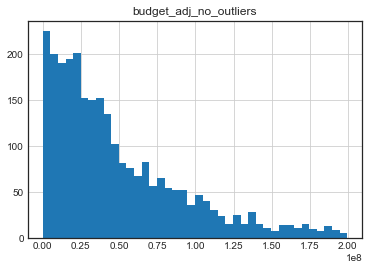

In [40]:
#Version with no outliers
boundary = movies_all['budget_adj'].quantile(q=0.98)
movies_all['budget_adj_no_outliers'] = movies_all['budget_adj'].apply(lambda x: np.nan if x>boundary else x)
movies_all.budget_adj_no_outliers.hist(bins=40)
plt.title('budget_adj_no_outliers')
plt.show()

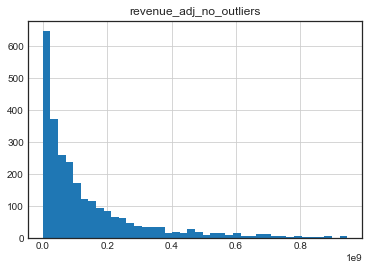

In [41]:
#Version with no outliers
boundary = movies_all['revenue_adj'].quantile(q=0.98)
movies_all['revenue_adj_no_outliers'] = movies_all['revenue_adj'].apply(lambda x: np.nan if x>boundary else x)
movies_all.revenue_adj_no_outliers.hist(bins=40)
plt.title('revenue_adj_no_outliers')
plt.show()

## Feature engineering

Some regression models are constrained by the range of existing values. To enable the model to predict revenue beyone the observed data, we will create a functional feature, ratio of revenue to budget, which can be used as an outcome variable. 

This feature will also be used in the classification models, to code sleeper hit films. 

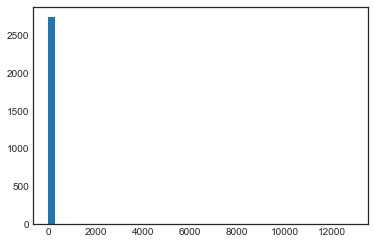

count     2748.000000
mean        14.135387
std        278.499686
min          0.000003
25%          0.982449
50%          2.244791
75%          4.419082
max      12890.386667
Name: rev_ratio, dtype: float64

In [42]:
movies_all['rev_ratio'] = movies_all['revenue']/movies_all['budget']
plt.hist(movies_all['rev_ratio'], bins=50)
plt.show()

movies_all['rev_ratio'].describe()

The distribution of this feature is problematic, exhibiting extreme outliers to the right. Let's investigate these outliers, to be sure that they are accurate, and then create a version of the feature without outliers for the regression models.

In [43]:
#Inspect the extreme outlier at the max.
movies_all.loc[movies_all['rev_ratio'].idxmax()]

budget                                   15000
id                                       23827
original_language                           en
popularity                             47.4568
revenue                              193355800
runtime                                     86
title                      Paranormal Activity
vote_average                               5.9
vote_count                                1316
Australia                                    0
Belgium                                      0
Brazil                                       0
Canada                                       0
China                                        0
Czech Republic                               0
Denmark                                      0
France                                       0
Germany                                      0
Hong Kong                                    0
Hungary                                      0
India                                        0
Ireland      

While the revenue-to-budget ratio value associated with *Paranormal Activity* is an extreme outlier, it is in fact accurate. *Paranormal Activity*, with its low budget and unexpectedly high revenue, is a prototypical example of a "sleeper hit".

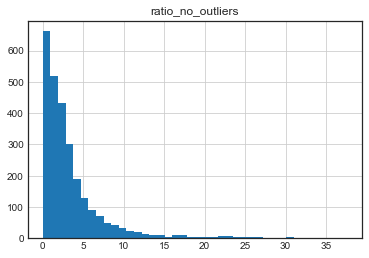

In [44]:
#Version with no outliers
boundary = movies_all['rev_ratio'].quantile(q=0.98)
movies_all['ratio_no_outliers'] = movies_all['rev_ratio'].apply(lambda x: np.nan if x>boundary else x)
movies_all.ratio_no_outliers.hist(bins=40)
plt.title('ratio_no_outliers')
plt.show()

A series of jointpolots shows the relationships between the ratio feature and the other continuous features. A second series visualizes the relationships between adjusted revenue and the others. The relationships appear to be either nonlinear or extremely weak, so our regression models may not be very robust, and are likely to depend more heavily on the categorical features.

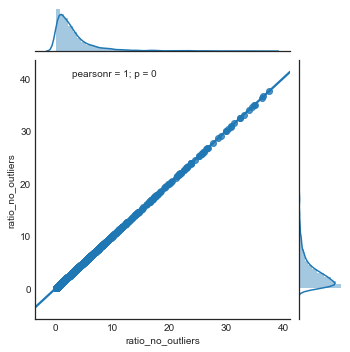

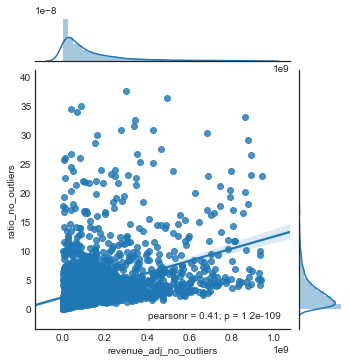

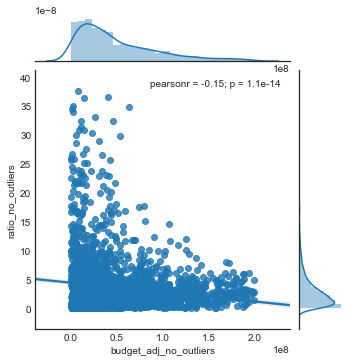

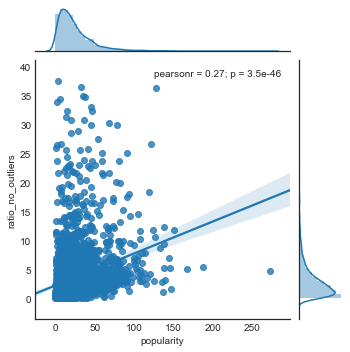

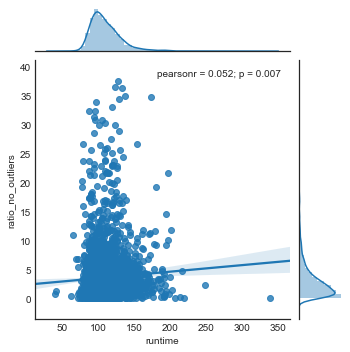

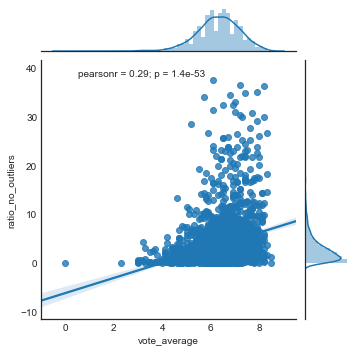

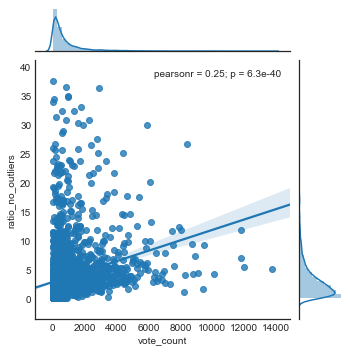

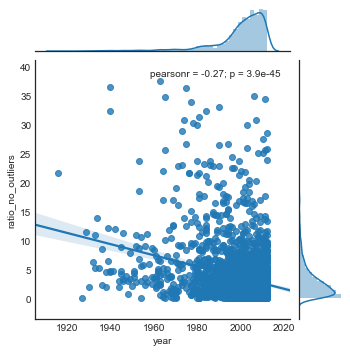

In [45]:
movies_continuous = movies_all[['ratio_no_outliers','revenue_adj_no_outliers','budget_adj_no_outliers','popularity','runtime','vote_average','vote_count', 'year']]
for col in movies_continuous:
    sns.jointplot(x=col, y='ratio_no_outliers', data=movies_continuous, kind='reg', size=5)#etc 

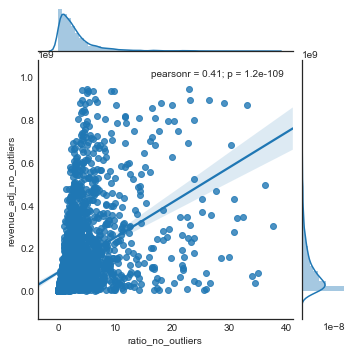

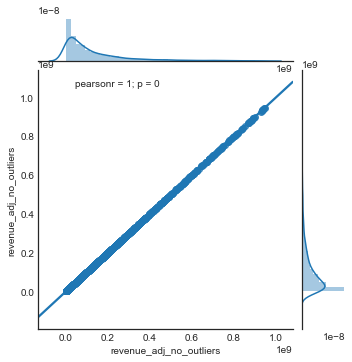

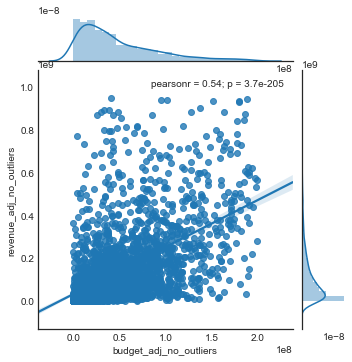

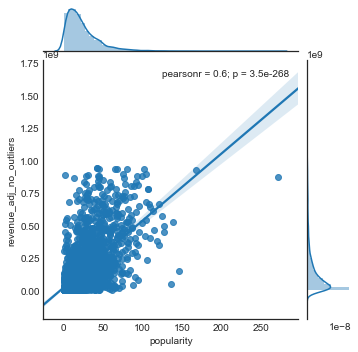

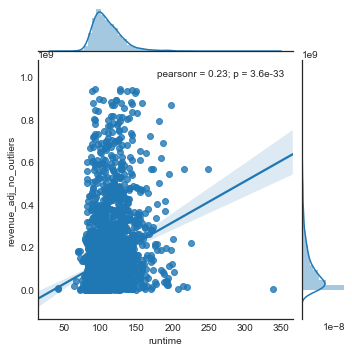

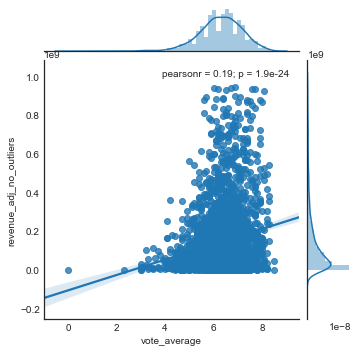

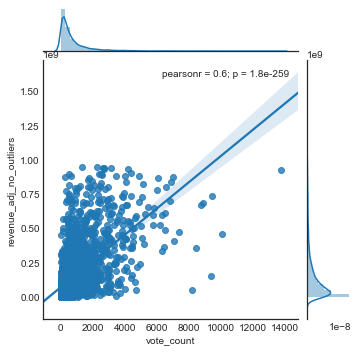

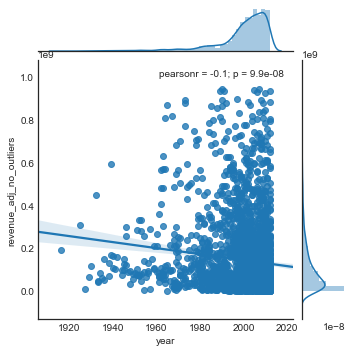

In [46]:
for col in movies_continuous:
    sns.jointplot(x=col, y='revenue_adj_no_outliers', data=movies_continuous, kind='reg', size=5)#etc 

                         ratio_no_outliers  revenue_adj_no_outliers  \
ratio_no_outliers                 1.000000                 0.413123   
revenue_adj_no_outliers           0.413123                 1.000000   
budget_adj_no_outliers           -0.149613                 0.544749   
popularity                        0.269951                 0.604591   
runtime                           0.051980                 0.228274   
vote_average                      0.290684                 0.194812   
vote_count                        0.250870                 0.596660   
year                             -0.266854                -0.102458   

                         budget_adj_no_outliers  popularity   runtime  \
ratio_no_outliers                     -0.149613    0.269951  0.051980   
revenue_adj_no_outliers                0.544749    0.604591  0.228274   
budget_adj_no_outliers                 1.000000    0.397552  0.265990   
popularity                             0.397552    1.000000  0.23543

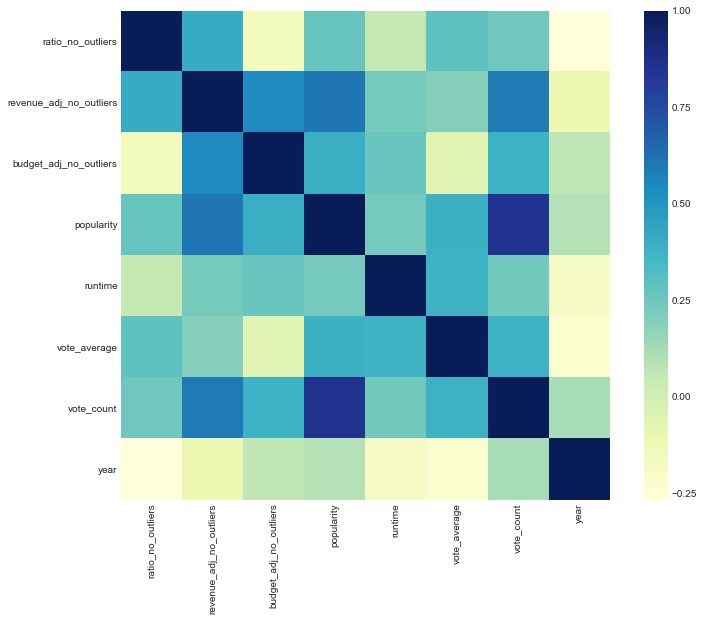

In [47]:
corrmat = movies_continuous.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=1, square=True, cmap="YlGnBu")
plt.show()

Box office success and later prestige (as a result of hype surrounding the Academy Awards) may be associated with the season a film is released in. The 'month' feature will therefore be coded into seasons relevant to the industry.

In [48]:
movies_all['early_summer'] = np.where(movies_all['month'].isin(['May', 'Jun', 'Jul']), 1, 0)
movies_all['late_summer'] = np.where(movies_all['month'].isin(['Aug', 'Sep']), 1, 0)
movies_all['late_year'] = np.where(movies_all['month'].isin(['Oct', 'Nov', 'Dec']), 1, 0)
movies_all['winter'] = np.where(movies_all['month'].isin(['Jan', 'Feb']), 1, 0)
movies_all['spring'] = np.where(movies_all['month'].isin(['Mar', 'Apr']), 1, 0)

In [49]:
df_to_model = movies_all.drop(['original_language','title'],1)
df_to_model = pd.get_dummies(movies_all)
df_to_model.drop([col for col, val in df_to_model.sum().iteritems() if val < 3], axis=1, inplace=True)

In [50]:
print(len(df_to_model))
null_count = df_to_model.isnull().sum()
null_count[null_count>0]

2748


budget_adj_no_outliers     54
revenue_adj_no_outliers    55
ratio_no_outliers          55
dtype: int64

In [51]:
df_to_model = df_to_model.dropna(how='any')
len(df_to_model)
null_count = df_to_model.isnull().sum()
null_count[null_count>0]

Series([], dtype: int64)

In [52]:
df_to_model.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,Australia,Belgium,Brazil,...,month_Dec,month_Feb,month_Jan,month_Jul,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep
9,150000000,18360,81.781591,413106170,105.0,5.9,1971,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,150000000,2080,5.954334,373062864,107.0,6.2,4021,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,150000000,13448,67.447636,356613439,138.0,6.5,2129,0,0,0,...,0,0,0,0,0,0,1,0,0,0
12,150000000,19585,26.710398,292817841,88.0,5.1,510,0,0,0,...,0,0,0,1,0,0,0,0,0,0
13,150000000,13475,73.616808,385680446,127.0,7.4,4518,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Regression models: Adjusted revenue

### Data preparation

To prepare the data for regression modeling, the predictor variables are selected, dummy-encoded, scaled, and normalized. The outcome variable, adjusted revenue, is log-transformed. 

In [53]:
#Define input variables.
X = df_to_model.drop(['id','revenue','revenue_adj', 'budget_adj','revenue_adj_no_outliers','rev_ratio','ratio_no_outliers','budget'],1)

In [54]:
#Scale and normalize.
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [55]:
#Select and log-transform outcome variable.
Y = df_to_model['revenue_adj_no_outliers'].apply(lambda x: np.log(x))

In [56]:
#Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)

### Design scorer

We will use root mean square error (RMSE) to evaluate the models. To establish a baseline for evaluating the models, the RMSE of the null model (predicting outcome mean alone) is computed for the test set.

In [57]:
#Declare custom scorer

def RMSE(y_true,y_pred):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: ', rmse)
    return rmse

def R2(y_true,y_pred):    
    r2 = r2_score(y_true, y_pred)
    print('R2: ', r2)
    return r2

def two_score(y_true,y_pred):    
    R2(y_true,y_pred) 
    score = RMSE(y_true,y_pred)
    return score

def two_scorer():
    return make_scorer(two_score, greater_is_better=False)

In [58]:
#Establish RMSE for null model.
dummy_array = np.ones_like(np.exp(y_test))
dummy_array = dummy_array * np.mean(np.exp(y_test))
rmse_null = RMSE(np.exp(y_test), dummy_array)
print('RMSE of null model: ',rmse_null)

RMSE:  174843536.71528926
RMSE of null model:  174843536.71528926


### Regression 1: OLS Regression

The first model is 'vanilla' OLS regression (without regularization). It is cross-validated using five folds, and evaluted on the test dataset.

In [59]:
#Declare and fit the model.
regr = linear_model.LinearRegression()
regr = regr.fit(X_train, y_train)

# Cross-validate.
cross_val_score(regr, X_train, y_train, cv=5, scoring=two_scorer())

R2:  -3.5830227102e+27
RMSE:  106270081077872.33
R2:  -2.81368790575e+26
RMSE:  31900885019357.633
R2:  -1.11334423343e+26
RMSE:  19203912648388.703
R2:  -5.32358721996e+27
RMSE:  133833301879299.7
R2:  -6.44059885194e+27
RMSE:  144613895173568.03


array([ -1.06270081e+14,  -3.19008850e+13,  -1.92039126e+13,
        -1.33833302e+14,  -1.44613895e+14])

In [60]:
#Extract predicted values.
predict_test = regr.predict(X_test)

#Exponentiate the values for model evaluation.
predicted = np.exp(predict_test)
actual = np.exp(y_test)

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Note the overflow when the predicted values are exponentiated--rmse cannot be computed because the values are too high.

In [61]:
#Compute rmse.
#RMSE(actual,predicted)

There appears to be an issue with heteroscedasticity in the residuals, based on the log-transformed predictions. 

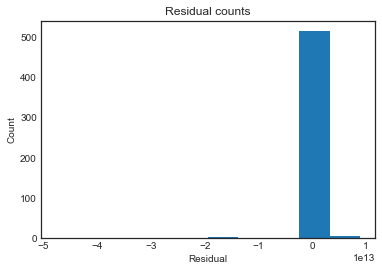

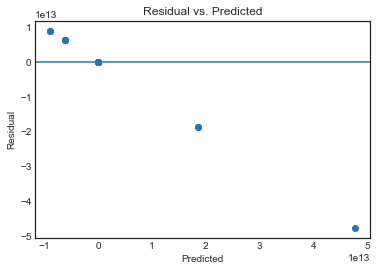

In [62]:
# Calculate the residual error.
residual = y_test - predict_test

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predict_test, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [63]:
co_dict = {'features': X_train.columns.values, 'coefficients': regr.coef_}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                     features  coef_absolute
300  9.335630e+11        lead_Daniel Radcliffe   9.335630e+11
786  6.857586e+11                    month_Dec   6.857586e+11
790  6.557034e+11                    month_Jun   6.557034e+11
794  6.335073e+11                    month_Oct   6.335073e+11
789  6.219496e+11                    month_Jul   6.219496e+11
793  6.060459e+11                    month_Nov   6.060459e+11
792  6.033282e+11                    month_May   6.033282e+11
527  5.128231e+11           lead2_Bill Pullman   5.128231e+11
404  5.016806e+11             lead_Mark Hamill   5.016806e+11
232 -4.824993e+11                 early_summer   4.824993e+11
233  4.762591e+11                  late_summer   4.762591e+11
234 -4.581462e+11                    late_year   4.581462e+11
610 -3.394849e+11           lead2_Ian McKellen   3.394849e+11
763 -2.458393e+11              lead2_Tim Allen   2.458393e+11
497 -2.070906e+11          lead_Zachary Gordon   2.070906e+11
787  2.0

### Regression 2: Ridge Regression

In [64]:
# Declare and fit the ridge model.
param_test = [{'alpha':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}]
ridge = Ridge(fit_intercept=False, random_state=10)
gsearch = GridSearchCV(ridge, param_test, cv=5, scoring=two_scorer())
gsearch.fit(X_train,y_train)

R2:  -19098.4506947
RMSE:  245.35599276658127
R2:  0.73500570866
RMSE:  0.9486177577647477
R2:  -15781.5907118
RMSE:  238.9207761562262
R2:  0.716450872273
RMSE:  0.96400434162077
R2:  -16087.7887967
RMSE:  230.8536072661858
R2:  0.738529309006
RMSE:  0.9368922726530037
R2:  -15977.845694
RMSE:  231.86473864374028
R2:  0.719276718428
RMSE:  0.9682665025624799
R2:  -8575.85307112
RMSE:  166.8825333844388
R2:  0.736442582485
RMSE:  0.9423150239397273
R2:  -18665.9681587
RMSE:  242.56220105020557
R2:  0.726131100266
RMSE:  0.9643714609260825
R2:  -15606.7363858
RMSE:  237.59359588468246
R2:  0.714195663852
RMSE:  0.9678303541401444
R2:  -15921.0287321
RMSE:  229.6540937748507
R2:  0.736560672639
RMSE:  0.9404126319280176
R2:  -15833.624688
RMSE:  230.81599070346363
R2:  0.717822299364
RMSE:  0.9707715422526605
R2:  -8527.99308738
RMSE:  166.4162686257543
R2:  0.73585714621
RMSE:  0.9433610187581198
R2:  -18038.7906962
RMSE:  238.4525541596088
R2:  0.68144579528
RMSE:  1.0400750109390304
R

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(two_score, greater_is_better=False), verbose=0)

In [65]:
gsearch.best_params_

{'alpha': 100000}

In [66]:
gsearch.best_score_

-17.957517456436559

NOTE: Something is weird here--when I ran this previously, it took the RMSE, which cannot be negative. 

In [67]:
ridge = Ridge(fit_intercept=False, random_state=10, alpha=100000)
ridge.fit(X_train, y_train) 

Ridge(alpha=100000, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001)

In [68]:
co_dict = {'features': X_train.columns.values, 'coefficients': ridge.coef_}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                        features  coef_absolute
0        0.019984                      popularity       0.019984
3        0.017567                      vote_count       0.017567
231      0.016136          budget_adj_no_outliers       0.016136
497     -0.012577             lead_Zachary Gordon       0.012577
294     -0.012069           lead_Cuba Gooding Jr.       0.012069
468     -0.011556               lead_Shia LaBeouf       0.011556
1        0.011406                         runtime       0.011406
30      -0.011320                     Switzerland       0.011320
780     -0.010843              lead2_Winona Ryder       0.010843
282     -0.010457                lead_Chevy Chase       0.010457
143     -0.010428            Media Rights Capital       0.010428
763     -0.010267                 lead2_Tim Allen       0.010267
527     -0.010267              lead2_Bill Pullman       0.010267
731     -0.010132             lead2_Robert Duvall       0.010132
684     -0.009918        

In [69]:
y_pred = ridge.predict(X_test)

predicted = np.exp(y_pred)
actual = np.exp(y_test)

RMSE(actual, predicted)

RMSE:  223894105.4597701


223894105.4597701

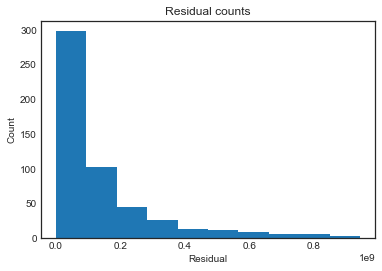

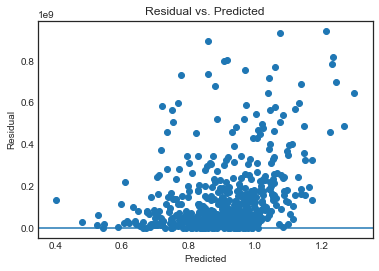

In [70]:
# Calculate the residual error.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Regression 3: Lasso Regression

In [71]:
# Declare and fit the ridge model.
param_test = [{'alpha':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}]
lasso = Lasso(fit_intercept=False, random_state=10)
gsearch = GridSearchCV(lasso, param_test, cv=5, scoring=two_scorer())
gsearch.fit(X_train,y_train)

R2:  -101780.198635
RMSE:  566.3957840422096
R2:  0.733952667232
RMSE:  0.9505007103429067


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2:  -131349.006074
RMSE:  689.2548304974803
R2:  0.715353223646
RMSE:  0.9658684206713686


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2:  -72545.6717606
RMSE:  490.2117721176373
R2:  0.737441062228
RMSE:  0.938839931351736


/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2:  -143412.933255
RMSE:  694.636627289784
R2:  0.718141172352
RMSE:  0.9702228803227357
R2:  -63061.3731652
RMSE:  452.5140352534428
R2:  0.735475835936
RMSE:  0.944041679843653
R2:  -74774.5077985
RMSE:  485.4739342246432
R2:  -1.45142274713
RMSE:  2.8852410129551065
R2:  -43347.7806562
RMSE:  395.9617297367593
R2:  -1.13453107523
RMSE:  2.644941512520477
R2:  -94466.6005297
RMSE:  559.3922330480519
R2:  -1.09463769336
RMSE:  2.651750179377826
R2:  -186869.103977
RMSE:  792.924650690049
R2:  -1.09628395625
RMSE:  2.645944600055847
R2:  -48214.2749389
RMSE:  395.67555722754736
R2:  -1.08200172797
RMSE:  2.6484942628427737
R2:  -41966.1487025
RMSE:  363.698042303238
R2:  -11.6483253972
RMSE:  6.553744497439762
R2:  -26384.8426616
RMSE:  308.9230073745923
R2:  -9.54845984202
RMSE:  5.879756744838685
R2:  -57384.4326615
RMSE:  435.9892889922738
R2:  -9.32366147079
RMSE:  5.887013437461317
R2:  -113828.178917
RMSE:  618.8548622933585
R2:  -9.36524230946
RMSE:  5.883630913159264
R2:  -293

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(two_score, greater_is_better=False), verbose=0)

In [72]:
gsearch.best_params_

{'alpha': 100}

In [73]:
gsearch.best_score_

-17.8775599999964

In [94]:
lasso = Lasso(fit_intercept=False, random_state=10, alpha=100)
lasso.fit(X_train, y_train) 

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=100, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=10,
   selection='cyclic', tol=0.0001, warm_start=False)

In [95]:
co_dict = {'features': X_train.columns.values, 'coefficients': lasso.coef_}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                          features  coef_absolute
163 -4.028948e+09                             Pathé   4.028948e+09
231  5.198784e+07            budget_adj_no_outliers   5.198784e+07
3    4.990379e+07                        vote_count   4.990379e+07
106  2.672771e+07                   Eon Productions   2.672771e+07
0    2.251321e+07                        popularity   2.251321e+07
196  1.859195e+07   Twentieth Century Fox Animation   1.859195e+07
481  1.847213e+07                   lead_Tom Cruise   1.847213e+07
232  1.655785e+07                      early_summer   1.655785e+07
429  1.647646e+07              lead_Patrick Stewart   1.647646e+07
420  1.604450e+07                   lead_Mike Myers   1.604450e+07
732  1.568302e+07            lead2_Robert Pattinson   1.568302e+07
230 -1.518394e+07                              year   1.518394e+07
733  1.452961e+07              lead2_Robert Redford   1.452961e+07
641 -1.251135e+07             lead2_Jonathan Frakes   1.251135

In [96]:
y_pred = lasso.predict(X_test)

predicted = np.exp(y_pred)
actual = np.exp(y_test)

RMSE(actual, predicted)

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

ValueError: max must be larger than min in range parameter.

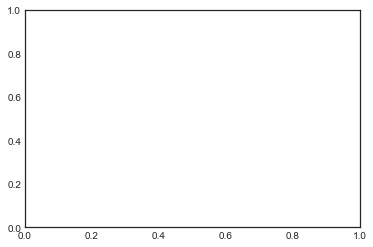

In [97]:
# Calculate the residual error.
residual = actual - predicted

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Regression models: Revenue-budget ratio


### Data preparation

In [78]:
#Define input variables.
X = df_to_model.drop(['id','revenue','revenue_adj','revenue_adj_no_outliers','budget', 'budget_adj','rev_ratio','ratio_no_outliers'],1)
#Scale and normalize.
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

In [79]:
#Select and log-transform outcome variable.
Y = df_to_model['revenue_adj_no_outliers']

In [80]:
#Split into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)

In [81]:
#Establish RMSE for null model.
dummy_array = np.ones_like(y_test)
dummy_array = dummy_array * np.mean(y_test)
rmse_null = RMSE(y_test, dummy_array)

RMSE:  178269023.41727543


### Regression 4: Ridge Regression redux

In [82]:
# Declare and fit the ridge model.
param_test = [{'alpha':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}]
ridge = Ridge(fit_intercept=False, random_state=10)
gsearch = GridSearchCV(ridge, param_test, cv=5, scoring=two_scorer())
gsearch.fit(X_train,y_train)

R2:  -159.365642693
RMSE:  1990563695.2842484
R2:  0.835630796754
RMSE:  69094045.75974812
R2:  -147.939391143
RMSE:  2118888933.783108
R2:  0.815787529644
RMSE:  71412454.5317467
R2:  -120.22833895
RMSE:  1855848242.6403394
R2:  0.828329774386
RMSE:  69467158.3465514
R2:  -95.8753159238
RMSE:  1773475077.9795625
R2:  0.818707359613
RMSE:  70100734.07154904
R2:  -192.190893271
RMSE:  2201446544.8261523
R2:  0.828412421704
RMSE:  70460967.97811165
R2:  -157.528948725
RMSE:  1979131742.0180337
R2:  0.83561395059
RMSE:  69097586.38599801
R2:  -146.037329904
RMSE:  2105315605.03258
R2:  0.815766335933
RMSE:  71416562.42800474
R2:  -119.017042899
RMSE:  1846553282.0885415
R2:  0.828316532692
RMSE:  69469837.45160887
R2:  -95.0792492436
RMSE:  1766173337.9256463
R2:  0.81869788931
RMSE:  70102564.9967919
R2:  -189.947035379
RMSE:  2188624614.0704284
R2:  0.828394675085
RMSE:  70464611.63245188
R2:  -154.807650319
RMSE:  1962071382.549644
R2:  0.835527380639
RMSE:  69115778.28044993
R2:  -143

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [0.001, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(two_score, greater_is_better=False), verbose=0)

In [83]:
gsearch.best_score_

-196398014.51757902

In [84]:
gsearch.best_params_

{'alpha': 10000}

In [98]:
ridge = Ridge(fit_intercept=False, random_state=10, alpha=10000)
ridge.fit(X_train, y_train) 

Ridge(alpha=10000, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=10, solver='auto', tol=0.001)

In [99]:
co_dict = {'features': X_train.columns.values, 'coefficients': ridge.coef_}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                         features  coef_absolute
0    1.193362e+07                       popularity   1.193362e+07
3    1.172475e+07                       vote_count   1.172475e+07
231  1.146554e+07           budget_adj_no_outliers   1.146554e+07
1    4.524751e+06                          runtime   4.524751e+06
106  4.315052e+06                  Eon Productions   4.315052e+06
481  4.289034e+06                  lead_Tom Cruise   4.289034e+06
210  3.891019e+06                        Adventure   3.891019e+06
232  3.744528e+06                     early_summer   3.744528e+06
2    3.721467e+06                     vote_average   3.721467e+06
733  3.415273e+06             lead2_Robert Redford   3.415273e+06
165  3.310711e+06          Pixar Animation Studios   3.310711e+06
577  3.279250e+06               lead2_Eddie Murphy   3.279250e+06
70   3.153720e+06             Amblin Entertainment   3.153720e+06
216  3.125430e+06                           Family   3.125430e+06
420  3.070

In [100]:
y_pred = ridge.predict(X_test)
RMSE(y_test, y_pred)

RMSE:  209869792.51080602


209869792.51080602

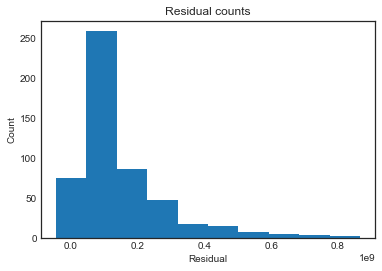

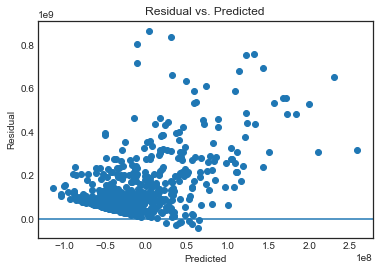

In [101]:
# Calculate the residual error.
residual = y_test - y_pred

#Check multivariate normality.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#Check homoscedasticity.
plt.scatter(y_pred, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Regression 5: Random Forest Regression

In [92]:
#Try to run all at once; at least the three most important. If not, do one at a time and then mess around by hand.
param_test = [{'n_estimators':[40, 60, 80, 100], 
               'max_depth':[2, 3, 4, 6, 8],
                'min_samples_split':[10, 50, 100, 200], 
                'min_samples_leaf':[10,20,50,100,200],
                'max_features':['sqrt','log2']
               }]
rfr = ensemble.RandomForestRegressor(random_state=10, bootstrap=True)
gsearch = GridSearchCV(rfr, param_test, cv=5, scoring=two_scorer())
gsearch.fit(X_train,y_train)

R2:  0.185466184368
RMSE:  141864905.7464775
R2:  0.195097558814
RMSE:  152898076.03001434
R2:  0.11882621811
RMSE:  162979953.3500686
R2:  0.123817729953
RMSE:  155744126.61274862
R2:  0.183352649828
RMSE:  152320256.12735692
R2:  0.203974544911
RMSE:  149587575.31725457
R2:  0.177250355113
RMSE:  163437750.32257888
R2:  0.180537064715
RMSE:  149038041.94582376
R2:  0.205262006455
RMSE:  141197434.86254418
R2:  0.220117081103
RMSE:  150217450.53609824
R2:  0.175083495549
RMSE:  142766203.52652958
R2:  0.182041468642
RMSE:  154133145.52995253
R2:  0.140731988763
RMSE:  160941382.57908112
R2:  0.146869434693
RMSE:  153681714.92124674
R2:  0.181219655601
RMSE:  152519048.39288753
R2:  0.205581108269
RMSE:  149436547.92574334
R2:  0.17171237589
RMSE:  163986882.6616607
R2:  0.173582222585
RMSE:  149669154.10634506
R2:  0.198566989454
RMSE:  141790923.96927923
R2:  0.213819601679
RMSE:  150822726.82532507
R2:  0.163789706583
RMSE:  143740174.92160895
R2:  0.172695342502
RMSE:  155011219.49

R2:  0.162532710012
RMSE:  154249693.35088357
R2:  0.187568685569
RMSE:  151121192.55837905
R2:  0.166603101886
RMSE:  164491879.83357972
R2:  0.169191103752
RMSE:  150066256.1250171
R2:  0.173588090673
RMSE:  143983624.7883661
R2:  0.183408992765
RMSE:  153712072.84122315
R2:  0.154612879984
RMSE:  144526747.0320678
R2:  0.160184813058
RMSE:  156178864.2586871
R2:  0.145532840698
RMSE:  160491151.6863153
R2:  0.150063719752
RMSE:  153393738.14657804
R2:  0.156670040734
RMSE:  154788662.33869565
R2:  0.179108931167
RMSE:  151905958.77995318
R2:  0.162415740818
RMSE:  164904602.6719308
R2:  0.164767944533
RMSE:  150465196.14046994
R2:  0.184636991439
RMSE:  143017875.17071024
R2:  0.192048768913
RMSE:  152896750.75538066
R2:  0.181970067787
RMSE:  142169033.81057376
R2:  0.184828350024
RMSE:  153870346.57114178
R2:  0.123326398067
RMSE:  162563248.97398347
R2:  0.12862839659
RMSE:  155315982.6375337
R2:  0.177705390495
RMSE:  152846009.38729537
R2:  0.200459752507
RMSE:  149917458.09543

R2:  0.154839356413
RMSE:  165648747.53176308
R2:  0.154850198893
RMSE:  151355889.76944572
R2:  0.178554620495
RMSE:  143550319.92511585
R2:  0.182493344941
RMSE:  153798227.77743623
R2:  0.170987537841
RMSE:  143120203.13898304
R2:  0.171420619289
RMSE:  155130595.31390494
R2:  0.140204964125
RMSE:  160990731.01923355
R2:  0.14622385688
RMSE:  153739850.65539664
R2:  0.158659796762
RMSE:  154605950.01214725
R2:  0.187168785722
RMSE:  151158380.87552965
R2:  0.155152603884
RMSE:  165618046.94220692
R2:  0.154200342328
RMSE:  151414069.22943273
R2:  0.182868567336
RMSE:  143172885.4343209
R2:  0.186858031686
RMSE:  153387112.17481327
R2:  0.156712584796
RMSE:  144347153.46892738
R2:  0.158809377425
RMSE:  156306705.53599158
R2:  0.129289392462
RMSE:  162009440.95766595
R2:  0.13519217937
RMSE:  154729902.33829147
R2:  0.144242535212
RMSE:  155924992.1259102
R2:  0.170384483486
RMSE:  152711055.1633095
R2:  0.14471072478
RMSE:  166638380.84447324
R2:  0.146112151374
RMSE:  152136315.927

R2:  0.125372142004
RMSE:  153972844.03759894
R2:  0.14365809444
RMSE:  146567748.89470544
R2:  0.144114822747
RMSE:  157366916.51579052
R2:  0.138421464536
RMSE:  145904218.86153138
R2:  0.139153288228
RMSE:  158122368.41335604
R2:  0.119742567373
RMSE:  162895188.3408589
R2:  0.126729071485
RMSE:  155485161.3029115
R2:  0.12688356002
RMSE:  157498515.79805622
R2:  0.149513860764
RMSE:  154619998.56467244
R2:  0.124008573371
RMSE:  168643051.46384013
R2:  0.124104358916
RMSE:  154084396.32778224
R2:  0.147447097559
RMSE:  146243134.79039624
R2:  0.147726950564
RMSE:  157034494.3392289
R2:  0.162391191902
RMSE:  143860323.3859711
R2:  0.158280994928
RMSE:  156355788.79947314
R2:  0.11218788367
RMSE:  163592707.29420078
R2:  0.119017927434
RMSE:  156170133.9046091
R2:  0.137495162353
RMSE:  156538494.43385202
R2:  0.162811830094
RMSE:  153406438.0853239
R2:  0.128615028283
RMSE:  168199057.06095743
R2:  0.129462736881
RMSE:  153612360.04302058
R2:  0.157789450072
RMSE:  145353387.581097

R2:  0.129601687396
RMSE:  146649111.00649357
R2:  0.125075353672
RMSE:  159410059.39636672
R2:  0.101083094184
RMSE:  164612639.93121323
R2:  0.106619172494
RMSE:  157265246.9496658
R2:  0.103379855842
RMSE:  159604315.00964668
R2:  0.122905039497
RMSE:  157020137.27290034
R2:  0.104304488595
RMSE:  170529187.51843652
R2:  0.104978289214
RMSE:  155757606.13243842
R2:  0.123716815272
RMSE:  148264459.31321546
R2:  0.123966417418
RMSE:  159208430.2119887
R2:  0.115247164653
RMSE:  147853427.25070658
R2:  0.111865896633
RMSE:  160608923.68158126
R2:  0.0946009585883
RMSE:  165205088.87054148
R2:  0.100674206627
RMSE:  157787636.8846326
R2:  0.0951440186518
RMSE:  160335656.17040142
R2:  0.114582748955
RMSE:  157763319.06945375
R2:  0.0909982093837
RMSE:  171791192.08106408
R2:  0.091294557608
RMSE:  156943756.45419523
R2:  0.110486334752
RMSE:  149379544.68312266
R2:  0.110636859909
RMSE:  160415099.7645982
R2:  0.104301736817
RMSE:  148765176.01888534
R2:  0.101198301036
RMSE:  16157060

R2:  0.0594785859668
RMSE:  153602810.88728845
R2:  0.0652175614418
RMSE:  164460253.41772783
R2:  0.0534507592193
RMSE:  152929764.63960218
R2:  0.0541491781156
RMSE:  165745490.43842852
R2:  0.0394954812777
RMSE:  170158289.77613282
R2:  0.0402560057046
RMSE:  163001705.62162018
R2:  0.0434377441312
RMSE:  164853056.20279965
R2:  0.0539675502842
RMSE:  163074126.72226506
R2:  0.0376634237933
RMSE:  176759197.13996577
R2:  0.0419289362795
RMSE:  161150382.417143
R2:  0.0557367773542
RMSE:  153908057.41967237
R2:  0.0604681868833
RMSE:  164877512.93491924
R2:  0.0737526355342
RMSE:  151280832.93962163
R2:  0.0755633271427
RMSE:  163858502.37384015
R2:  0.0506166512967
RMSE:  169170335.6169161
R2:  0.0524393837317
RMSE:  161963796.43734467
R2:  0.0561967577792
RMSE:  163749927.041107
R2:  0.0670576459528
RMSE:  161941981.79709607
R2:  0.0465315649639
RMSE:  175942874.88829866
R2:  0.0489433998924
RMSE:  160559371.91942412
R2:  0.0797492352206
RMSE:  151938527.33588886
R2:  0.08637966574

R2:  0.0789712604238
RMSE:  152002737.7542237
R2:  0.0843628855557
RMSE:  162767381.4443282
R2:  0.0541690789587
RMSE:  152871725.75839698
R2:  0.0553837882338
RMSE:  165637282.1067457
R2:  0.0393267127405
RMSE:  170173238.22444266
R2:  0.0401241243842
RMSE:  163012904.5152087
R2:  0.0420312769075
RMSE:  164974206.31786528
R2:  0.0499218092296
RMSE:  163422450.8345933
R2:  0.0324656003211
RMSE:  177235914.87451863
R2:  0.0342430514595
RMSE:  161795485.47004676
R2:  0.0548452986428
RMSE:  153980692.5624563
R2:  0.0590644628238
RMSE:  165000636.04015425
R2:  0.0450848118247
RMSE:  153604102.4231604
R2:  0.0450943357189
RMSE:  166536960.12781253
R2:  0.0332909896254
RMSE:  170706983.8343616
R2:  0.034771359403
RMSE:  163466794.80131748
R2:  0.0354086619919
RMSE:  165543472.7477775
R2:  0.0431959218414
RMSE:  163999888.85224578
R2:  0.0313263147956
RMSE:  177340233.0805903
R2:  0.0330857231079
RMSE:  161892401.3854843
R2:  0.0467454237339
RMSE:  154639084.03556338
R2:  0.0497977103776
RMSE

R2:  0.0276293250961
RMSE:  162348546.61669582
R2:  0.0345475557148
RMSE:  155625321.76551226
R2:  0.0368942902013
RMSE:  166933178.0517156
R2:  0.0444199841328
RMSE:  153657563.97339872
R2:  0.0440344311075
RMSE:  166629358.9611294
R2:  0.0329019609701
RMSE:  170741328.8273967
R2:  0.0338089765653
RMSE:  163548266.91959104
R2:  0.0363084085407
RMSE:  165466247.340412
R2:  0.0455032007923
RMSE:  163802031.2687363
R2:  0.0306535231806
RMSE:  177401808.15671825
R2:  0.0321245613043
RMSE:  161972846.02554533
R2:  0.035057902972
RMSE:  155584183.82273287
R2:  0.0366567270754
RMSE:  166953764.9519891
R2:  0.0547274016114
RMSE:  152826599.11629885
R2:  0.0544918484588
RMSE:  165715463.92270195
R2:  0.0342377925829
RMSE:  170623367.42588064
R2:  0.038984775075
RMSE:  163109621.9990549
R2:  0.0429727452945
RMSE:  164893120.06962737
R2:  0.0538242586839
RMSE:  163086476.3344994
R2:  0.0347486809399
RMSE:  177026680.5192019
R2:  0.0340424817142
RMSE:  161812285.55346602
R2:  0.0538577044717
RMSE

R2:  0.0411248307625
RMSE:  165052238.55007353
R2:  0.0518961343976
RMSE:  163252561.2103882
R2:  0.0346682363568
RMSE:  177034057.11663544
R2:  0.033998187796
RMSE:  161815995.45677632
R2:  0.0526369167285
RMSE:  154160477.82653826
R2:  0.0514741637023
RMSE:  165664809.38634777
R2:  0.0390315753025
RMSE:  154090183.86545822
R2:  0.0372943758644
RMSE:  167215739.09588072
R2:  0.0225360952719
RMSE:  171653937.5959496
R2:  0.0257447463477
RMSE:  164229369.4484989
R2:  0.0291629152953
RMSE:  166078556.49507344
R2:  0.037414030375
RMSE:  164494661.6967551
R2:  0.0235750972181
RMSE:  178048347.61188307
R2:  0.0231536514421
RMSE:  162721750.43761134
R2:  0.0386684839017
RMSE:  155292831.75256038
R2:  0.038744388133
RMSE:  166772764.09798306
R2:  0.0304847455565
RMSE:  154773904.1525883
R2:  0.0290188653024
RMSE:  167932902.51713282
R2:  0.0181518003844
RMSE:  172038473.26097602
R2:  0.0207062866284
RMSE:  164653486.22374794
R2:  0.022489852395
RMSE:  166648350.7430341
R2:  0.0298650081388
RM

R2:  0.221811506489
RMSE:  150339395.8778817
R2:  0.189730089782
RMSE:  156285347.04363993
R2:  0.19597753534
RMSE:  149193031.58694327
R2:  0.204511936128
RMSE:  150334001.1752545
R2:  0.24011901455
RMSE:  146152023.7911647
R2:  0.208650473053
RMSE:  160288622.81461218
R2:  0.222237840572
RMSE:  145196411.65377402
R2:  0.244569932907
RMSE:  137661327.2106865
R2:  0.26486503175
RMSE:  145844220.42316276
R2:  0.200868781579
RMSE:  140517192.09681126
R2:  0.218169669466
RMSE:  150690771.22164786
R2:  0.19981599848
RMSE:  155309613.08668038
R2:  0.208534552859
RMSE:  148023417.59996146
R2:  0.196642816591
RMSE:  151075737.63535425
R2:  0.231537304664
RMSE:  146974990.13475484
R2:  0.207377417304
RMSE:  160417500.34891534
R2:  0.221604203909
RMSE:  145255544.79498696
R2:  0.240710845213
RMSE:  138012498.2985867
R2:  0.2587304091
RMSE:  146451483.37610656
R2:  0.223862198821
RMSE:  138480885.64197335
R2:  0.249367511634
RMSE:  147653612.51600733
R2:  0.168213406522
RMSE:  158346826.48391494

R2:  0.209699524904
RMSE:  149843015.4447387
R2:  0.242923519168
RMSE:  145882071.70375767
R2:  0.212038687084
RMSE:  159945111.69138968
R2:  0.224653654042
RMSE:  144970738.38913876
R2:  0.272861754238
RMSE:  135058932.64698038
R2:  0.286129608007
RMSE:  143719390.79181835
R2:  0.202134225838
RMSE:  140405891.7746457
R2:  0.214002684565
RMSE:  151091812.01587903
R2:  0.180318585441
RMSE:  157190374.90064156
R2:  0.18741915162
RMSE:  149984969.24167472
R2:  0.213045366493
RMSE:  149525488.90333927
R2:  0.24692789382
RMSE:  145495756.06271935
R2:  0.2152291849
RMSE:  159620970.05388996
R2:  0.22848711205
RMSE:  144611913.03059012
R2:  0.25715589641
RMSE:  136509746.25548103
R2:  0.273686799082
RMSE:  144966499.29323488
R2:  0.197106053245
RMSE:  140847617.86841232
R2:  0.208979601563
RMSE:  151573835.3028653
R2:  0.173529243013
RMSE:  157840028.80834004
R2:  0.181341697336
RMSE:  150544808.1592445
R2:  0.197695531234
RMSE:  150976720.79713124
R2:  0.229235978386
RMSE:  147194899.6739391

R2:  0.189048395123
RMSE:  162261689.17894676
R2:  0.194659998543
RMSE:  147748171.3010459
R2:  0.213595635266
RMSE:  140455185.22317916
R2:  0.227317697961
RMSE:  149522367.5969589
R2:  0.170018719195
RMSE:  143203806.84897032
R2:  0.175119377161
RMSE:  154783958.46539924
R2:  0.163308862804
RMSE:  158812978.1919254
R2:  0.169923341334
RMSE:  151591045.48247552
R2:  0.181040815888
RMSE:  152535704.24803317
R2:  0.212658121904
RMSE:  148769437.44161725
R2:  0.186786875338
RMSE:  162487783.15184298
R2:  0.193455503765
RMSE:  147858618.69516212
R2:  0.215166272564
RMSE:  140314853.8475481
R2:  0.22662866407
RMSE:  149589020.48943576
R2:  0.199261112763
RMSE:  140658465.2691092
R2:  0.206714769992
RMSE:  151790671.57850626
R2:  0.143917831977
RMSE:  160642750.4036484
R2:  0.148620193401
RMSE:  153523944.3574277
R2:  0.1916616865
RMSE:  151543378.32403243
R2:  0.227755935944
RMSE:  147336155.7589496
R2:  0.184868471028
RMSE:  162679328.04461598
R2:  0.187010060701
RMSE:  148448243.87778828

R2:  0.133385878426
RMSE:  167737978.49088994
R2:  0.13801587881
RMSE:  152855866.5778706
R2:  0.166783374896
RMSE:  144575193.61114442
R2:  0.163878745513
RMSE:  155539362.4432981
R2:  0.164208869129
RMSE:  143704144.48134166
R2:  0.159155254558
RMSE:  156274567.4734009
R2:  0.136070408541
RMSE:  161377350.39190003
R2:  0.143137223205
RMSE:  154017505.6829312
R2:  0.157952027942
RMSE:  154670966.67656022
R2:  0.189482153823
RMSE:  150943124.53986242
R2:  0.14220105017
RMSE:  166882685.19150263
R2:  0.145084912035
RMSE:  152227799.50776643
R2:  0.177172800679
RMSE:  143671008.00250983
R2:  0.175844489287
RMSE:  154422388.7148031
R2:  0.148777123389
RMSE:  145024727.39520958
R2:  0.147208966613
RMSE:  157380786.36282146
R2:  0.128262408858
RMSE:  162104956.04985854
R2:  0.135235307502
RMSE:  154726044.08524114
R2:  0.146643052397
RMSE:  155706143.03688213
R2:  0.174597399517
RMSE:  152322816.4617657
R2:  0.138189795877
RMSE:  167272419.95196608
R2:  0.141777257356
RMSE:  152521998.84704

R2:  0.0928204496357
RMSE:  171618914.16423365
R2:  0.0945563317424
RMSE:  156661830.50537664
R2:  0.115209472793
RMSE:  148982429.2135351
R2:  0.11470430547
RMSE:  160047855.28069156
R2:  0.105994770717
RMSE:  148624512.79192328
R2:  0.102414869019
RMSE:  161461217.55165952
R2:  0.108501993437
RMSE:  163931945.85626924
R2:  0.115082328243
RMSE:  156518573.54741833
R2:  0.0989134844795
RMSE:  160001343.0100989
R2:  0.117561790874
RMSE:  157497693.1575467
R2:  0.0956206672618
RMSE:  171353838.89369726
R2:  0.0963340243877
RMSE:  156507964.8239496
R2:  0.114080042599
RMSE:  149077486.50986335
R2:  0.113124766779
RMSE:  160190569.8110166
R2:  0.143542199027
RMSE:  145469986.70171174
R2:  0.13919772431
RMSE:  158118287.2982126
R2:  0.089551500215
RMSE:  165665127.110107
R2:  0.0944743810029
RMSE:  158330585.6349805
R2:  0.0930034344655
RMSE:  160525194.19410512
R2:  0.111084798401
RMSE:  158074643.6604725
R2:  0.109006296292
RMSE:  170081015.9965882
R2:  0.109912357583
RMSE:  155327683.165

R2:  0.0604677441552
RMSE:  174652324.9806896
R2:  0.0655145307685
RMSE:  159154438.61413383
R2:  0.0860699942384
RMSE:  151415831.99260664
R2:  0.0934077921402
RMSE:  161961456.50940043
R2:  0.0708351952037
RMSE:  151518893.43487442
R2:  0.0755426007195
RMSE:  163860339.26636913
R2:  0.0611506833465
RMSE:  168229189.66268545
R2:  0.0616332650518
RMSE:  161176139.40761042
R2:  0.0529454796034
RMSE:  164031733.04647654
R2:  0.0626521207112
RMSE:  162323891.36529025
R2:  0.0566411769156
RMSE:  175007629.3109819
R2:  0.0642006597553
RMSE:  159266283.56051397
R2:  0.0806312289954
RMSE:  151865698.83889624
R2:  0.0895449551947
RMSE:  162306135.01079327
R2:  0.0595308419399
RMSE:  152437807.34923854
R2:  0.0621931768567
RMSE:  165039193.37899318
R2:  0.0569094906404
RMSE:  168608743.8814364
R2:  0.059303172063
RMSE:  161376126.53874546
R2:  0.0458186698125
RMSE:  164647765.11147943
R2:  0.056662416915
RMSE:  162841694.72030017
R2:  0.0564255484461
RMSE:  175027629.37361515
R2:  0.06365492644

R2:  0.0424761693687
RMSE:  164935893.84357676
R2:  0.0518564091897
RMSE:  163255981.28609836
R2:  0.0485427224755
RMSE:  175757218.17832083
R2:  0.0531779697621
RMSE:  160201528.66386506
R2:  0.0542399591631
RMSE:  154029994.37114346
R2:  0.0584917601156
RMSE:  165050842.4214201
R2:  0.065929206956
RMSE:  151918376.53360724
R2:  0.0678321204413
RMSE:  164542262.73605967
R2:  0.0523020072044
RMSE:  169020112.38466373
R2:  0.0540491741335
RMSE:  161826159.5459261
R2:  0.0486123936352
RMSE:  164406554.37183103
R2:  0.0583585890599
RMSE:  162695229.75253764
R2:  0.0533277956202
RMSE:  175314701.61128417
R2:  0.0577546889101
RMSE:  159813871.02864388
R2:  0.0536731395523
RMSE:  154076144.63136798
R2:  0.0572881190011
RMSE:  165156310.71091273
R2:  0.0650097776858
RMSE:  151993126.67451167
R2:  0.0663314087457
RMSE:  164674659.05603692
R2:  0.0452042517269
RMSE:  169651867.22593853
R2:  0.0476371746061
RMSE:  162373691.62006786
R2:  0.0483091034243
RMSE:  164432757.63794857
R2:  0.061254117

R2:  0.0347486809399
RMSE:  177026680.5192019
R2:  0.0340424817142
RMSE:  161812285.55346602
R2:  0.0538577044717
RMSE:  154061118.93618602
R2:  0.0537877537602
RMSE:  165462645.96301314
R2:  0.0406604436882
RMSE:  153959534.89057365
R2:  0.0402460298674
RMSE:  166959200.70542103
R2:  0.0278289421457
RMSE:  171188564.2715802
R2:  0.0304382975946
RMSE:  163833297.89944255
R2:  0.0326932659015
RMSE:  165776317.56516877
R2:  0.0412004086719
RMSE:  164170819.0810802
R2:  0.0244258904394
RMSE:  177970760.82608294
R2:  0.0239199268733
RMSE:  162657915.3513162
R2:  0.0399435005884
RMSE:  155189814.92414737
R2:  0.0420278864685
RMSE:  166487685.6473509
R2:  0.033266913685
RMSE:  154551671.24389783
R2:  0.0326849279246
RMSE:  167615576.70452636
R2:  0.0235006644935
RMSE:  171569221.95002863
R2:  0.0259398547282
RMSE:  164212923.99922654
R2:  0.0276115749551
RMSE:  166211195.39269587
R2:  0.0356965039576
RMSE:  164641348.86158788
R2:  0.0228669790536
RMSE:  178112897.5933418
R2:  0.0223432805524

R2:  0.0181518003844
RMSE:  172038473.26097602
R2:  0.0207062866284
RMSE:  164653486.22374794
R2:  0.022489852395
RMSE:  166648350.7430341
R2:  0.0298650081388
RMSE:  165138421.71617296
R2:  0.0199067526227
RMSE:  178382490.2536768
R2:  0.0194885395917
RMSE:  163026729.33685032
R2:  0.0316842165429
RMSE:  155855927.72413313
R2:  0.0321200331458
RMSE:  167346422.748692
R2:  0.0278339971681
RMSE:  154985343.1323412
R2:  0.0265724087702
RMSE:  168144328.9144263
R2:  0.0186058399181
RMSE:  171998690.48155004
R2:  0.0207315431127
RMSE:  164651362.96136063
R2:  0.021203903282
RMSE:  166757930.6105331
R2:  0.0282820349219
RMSE:  165273095.31930026
R2:  0.0192877615856
RMSE:  178438811.2897529
R2:  0.019693807862
RMSE:  163009663.7707106
R2:  0.0314835979457
RMSE:  155872072.2395669
R2:  0.0323566727905
RMSE:  167325964.0037071
R2:  0.0551483526959
RMSE:  152792566.77127606
R2:  0.0536700287891
RMSE:  165787466.8172974
R2:  0.033287684295
RMSE:  170707275.6711449
R2:  0.037912968678
RMSE:  163

R2:  0.256233479327
RMSE:  145364612.6706454
R2:  0.291502204103
RMSE:  141124136.1732417
R2:  0.277428774967
RMSE:  153164760.1948624
R2:  0.290759301799
RMSE:  138653010.30790016
R2:  0.295203798981
RMSE:  132967834.64410338
R2:  0.312016000822
RMSE:  141089551.06109068
R2:  0.263185786142
RMSE:  134927170.1796691
R2:  0.287606004314
RMSE:  143843593.30978987
R2:  0.253219526915
RMSE:  150037521.88631403
R2:  0.261139018065
RMSE:  143019683.82874247
R2:  0.26176163791
RMSE:  144823382.7271614
R2:  0.301487766789
RMSE:  140126105.87190068
R2:  0.284505015747
RMSE:  152412933.05034426
R2:  0.294771759382
RMSE:  138260246.31676
R2:  0.28956891468
RMSE:  133498319.0091619
R2:  0.304273941436
RMSE:  141881188.5158788
R2:  0.257458698665
RMSE:  135450534.08712113
R2:  0.281205578738
RMSE:  144488321.9037646
R2:  0.251520144865
RMSE:  150208138.41410977
R2:  0.256592021559
RMSE:  143459084.86169058
R2:  0.242501671741
RMSE:  146700374.34393764
R2:  0.281737796105
RMSE:  142093284.04174754
R

R2:  0.244428012771
RMSE:  156623328.07560882
R2:  0.25542397703
RMSE:  142064969.39609206
R2:  0.26954136682
RMSE:  135366946.42776084
R2:  0.282328431064
RMSE:  144101517.25321904
R2:  0.224666704745
RMSE:  138409095.8271716
R2:  0.237314990524
RMSE:  148834291.18744102
R2:  0.235081935465
RMSE:  151848625.26982245
R2:  0.246721790766
RMSE:  144408298.00444534
R2:  0.229634474552
RMSE:  147941086.00367677
R2:  0.262293901306
RMSE:  144003726.81061354
R2:  0.241798922261
RMSE:  156895584.9414207
R2:  0.252403671029
RMSE:  142352814.7039363
R2:  0.275657752488
RMSE:  134799017.66353908
R2:  0.286333670583
RMSE:  143698847.95537895
R2:  0.234934153208
RMSE:  137489591.60858372
R2:  0.254076013363
RMSE:  147189789.69079024
R2:  0.189222751442
RMSE:  156334267.24904117
R2:  0.195572609002
RMSE:  149230595.57688212
R2:  0.248831276751
RMSE:  146086179.38594317
R2:  0.284963993919
RMSE:  141773806.7196802
R2:  0.268179459734
RMSE:  154141940.26206136
R2:  0.27604100796
RMSE:  140084299.2715

R2:  0.201541561665
RMSE:  140458029.6762596
R2:  0.212110883807
RMSE:  151273532.62270063
R2:  0.195383284219
RMSE:  155739196.9943025
R2:  0.200818746808
RMSE:  148743189.9589948
R2:  0.211233377712
RMSE:  149697533.58991042
R2:  0.249927031449
RMSE:  145205745.90482315
R2:  0.211324453275
RMSE:  160017585.00256813
R2:  0.219522495658
RMSE:  145449647.69840845
R2:  0.244506259465
RMSE:  137667128.66489252
R2:  0.252040173996
RMSE:  147110888.5601331
R2:  0.189321972156
RMSE:  141528731.95189404
R2:  0.196296125938
RMSE:  152784194.60131142
R2:  0.186156571703
RMSE:  156629599.056067
R2:  0.18971734649
RMSE:  149772720.3590144
R2:  0.199607933225
RMSE:  150796676.6531616
R2:  0.235290148291
RMSE:  146615669.3629254
R2:  0.202692602283
RMSE:  160890877.66784078
R2:  0.211374072311
RMSE:  146206945.5821698
R2:  0.223369612788
RMSE:  139579619.07336873
R2:  0.23324734419
RMSE:  148947537.36398646
R2:  0.188240289142
RMSE:  141623120.96184117
R2:  0.194397929495
RMSE:  152964511.87125698


R2:  0.150838959393
RMSE:  157045475.40561128
R2:  0.138588021577
RMSE:  161142040.62206224
R2:  0.14561534617
RMSE:  153794628.29406536
R2:  0.144078040275
RMSE:  155939977.46952266
R2:  0.16982631788
RMSE:  152762418.55077067
R2:  0.140106588473
RMSE:  167086297.17618695
R2:  0.142093875402
RMSE:  152493861.82066292
R2:  0.169160551351
RMSE:  144368808.9702622
R2:  0.169753733025
RMSE:  154991952.21071804
R2:  0.16873263494
RMSE:  143314713.48956665
R2:  0.163202934258
RMSE:  155897974.48094577
R2:  0.134908599863
RMSE:  161485823.70758268
R2:  0.142713827206
RMSE:  154055552.81484193
R2:  0.157787682449
RMSE:  154686059.7810478
R2:  0.185897567743
RMSE:  151276535.89779252
R2:  0.139519201304
RMSE:  167143355.173825
R2:  0.14465083422
RMSE:  152266440.9622471
R2:  0.167081854936
RMSE:  144549295.97925562
R2:  0.164279401025
RMSE:  155502092.02963606
R2:  0.170237564647
RMSE:  143184925.9605113
R2:  0.164988992949
RMSE:  155731511.38045612
R2:  0.142626187811
RMSE:  160763892.4344697

R2:  0.104111304017
RMSE:  159539200.42093766
R2:  0.123924462758
RMSE:  156928860.65754977
R2:  0.104483164411
RMSE:  170512177.8533608
R2:  0.105240655606
RMSE:  155734775.09044847
R2:  0.127970727435
RMSE:  147904146.9743101
R2:  0.127752173706
RMSE:  158864050.21169657
R2:  0.117325419122
RMSE:  147679673.80695513
R2:  0.11335477752
RMSE:  160474243.6489175
R2:  0.0966720198922
RMSE:  165016030.93117312
R2:  0.10270581539
RMSE:  157609312.19208044
R2:  0.0963285762425
RMSE:  160230673.15538335
R2:  0.116077498802
RMSE:  157630095.83122268
R2:  0.0928204496357
RMSE:  171618914.16423365
R2:  0.0945563317424
RMSE:  156661830.50537664
R2:  0.115209472793
RMSE:  148982429.2135351
R2:  0.11470430547
RMSE:  160047855.28069156
R2:  0.105994770717
RMSE:  148624512.79192328
R2:  0.102414869019
RMSE:  161461217.55165952
R2:  0.108501993437
RMSE:  163931945.85626924
R2:  0.115082328243
RMSE:  156518573.54741833
R2:  0.0991668644362
RMSE:  159978845.73428333
R2:  0.117932891846
RMSE:  157464572

R2:  0.0585310143511
RMSE:  163547304.84257916
R2:  0.0709549299625
RMSE:  161603378.66678563
R2:  0.0708554572754
RMSE:  173684140.6401702
R2:  0.0806445469146
RMSE:  157860766.3829079
R2:  0.0775305803536
RMSE:  152121573.21342364
R2:  0.0858955394073
RMSE:  162631098.9964061
R2:  0.0916915755715
RMSE:  149808717.30871686
R2:  0.100423715609
RMSE:  161640206.6771817
R2:  0.0660807202214
RMSE:  167786910.0784799
R2:  0.0677227636066
RMSE:  160652314.69054657
R2:  0.0737588705037
RMSE:  162219259.1305745
R2:  0.0856149482838
RMSE:  160323285.2808579
R2:  0.0620898237476
RMSE:  174501493.3548203
R2:  0.0666627926386
RMSE:  159056626.95557758
R2:  0.0874850032472
RMSE:  151298570.40789112
R2:  0.0949744072886
RMSE:  161821459.17796162
R2:  0.0739813268296
RMSE:  151262156.1008436
R2:  0.0814542929455
RMSE:  163335574.41163376
R2:  0.0583758274693
RMSE:  168477614.6920565
R2:  0.0592466753608
RMSE:  161380972.45817688
R2:  0.0565804493666
RMSE:  163716638.3991751
R2:  0.0650005507844
RMSE

R2:  0.0356812232702
RMSE:  170495812.6845283
R2:  0.0376742841788
RMSE:  163220796.53999078
R2:  0.0375090339573
RMSE:  165363141.27459243
R2:  0.046869408518
RMSE:  163684761.238555
R2:  0.0289906712782
RMSE:  177553903.6866705
R2:  0.0296842364023
RMSE:  162176910.2671991
R2:  0.0393500687084
RMSE:  155237770.62084305
R2:  0.0423645660164
RMSE:  166458427.00621852
R2:  0.0397974288083
RMSE:  154028769.76158595
R2:  0.0400735229732
RMSE:  166974204.71685174
R2:  0.0303602864907
RMSE:  170965548.1419179
R2:  0.0332929298126
RMSE:  163591937.00325036
R2:  0.0363524733307
RMSE:  165462464.32577792
R2:  0.0444429572353
RMSE:  163892980.681834
R2:  0.0395139051651
RMSE:  176589169.83269054
R2:  0.040114734103
RMSE:  161302887.33751678
R2:  0.0348962619172
RMSE:  155597214.520923
R2:  0.0370724405992
RMSE:  166917738.11237648
R2:  0.0508908437864
RMSE:  153136422.1031414
R2:  0.0499822046334
RMSE:  166110187.51380327
R2:  0.0339389168201
RMSE:  170649766.90802726
R2:  0.036377959672
RMSE: 

R2:  0.024466803713
RMSE:  171484326.46226877
R2:  0.0264517751959
RMSE:  164169767.01082763
R2:  0.030932908491
RMSE:  165927093.378823
R2:  0.0382139530442
RMSE:  164426298.78622046
R2:  0.0235598057153
RMSE:  178049741.78778714
R2:  0.0239195483633
RMSE:  162657946.88952821
R2:  0.0320246802102
RMSE:  155828525.53429213
R2:  0.0335360371274
RMSE:  167223964.4163021
R2:  0.0547274016114
RMSE:  152826599.11629885
R2:  0.0544918484588
RMSE:  165715463.92270195
R2:  0.0342377925829
RMSE:  170623367.42588064
R2:  0.038984775075
RMSE:  163109621.9990549
R2:  0.0441905889006
RMSE:  164788171.14732286
R2:  0.0555492739446
RMSE:  162937743.39302415
R2:  0.0347486809399
RMSE:  177026680.5192019
R2:  0.0340424817142
RMSE:  161812285.55346602
R2:  0.0538577044717
RMSE:  154061118.93618602
R2:  0.0537877537602
RMSE:  165462645.96301314
R2:  0.0406604436882
RMSE:  153959534.89057365
R2:  0.0402460298674
RMSE:  166959200.70542103
R2:  0.0278289421457
RMSE:  171188564.2715802
R2:  0.0304382975946
R

R2:  0.0390315753025
RMSE:  154090183.86545822
R2:  0.0372943758644
RMSE:  167215739.09588072
R2:  0.0225360952719
RMSE:  171653937.5959496
R2:  0.0257447463477
RMSE:  164229369.4484989
R2:  0.0291629152953
RMSE:  166078556.49507344
R2:  0.037414030375
RMSE:  164494661.6967551
R2:  0.0235750972181
RMSE:  178048347.61188307
R2:  0.0231536514421
RMSE:  162721750.43761134
R2:  0.0386684839017
RMSE:  155292831.75256038
R2:  0.038744388133
RMSE:  166772764.09798306
R2:  0.0304847455565
RMSE:  154773904.1525883
R2:  0.0290188653024
RMSE:  167932902.51713282
R2:  0.0181518003844
RMSE:  172038473.26097602
R2:  0.0207062866284
RMSE:  164653486.22374794
R2:  0.022489852395
RMSE:  166648350.7430341
R2:  0.0298650081388
RMSE:  165138421.71617296
R2:  0.0199067526227
RMSE:  178382490.2536768
R2:  0.0194885395917
RMSE:  163026729.33685032
R2:  0.0316842165429
RMSE:  155855927.72413313
R2:  0.0321200331458
RMSE:  167346422.748692
R2:  0.0278339971681
RMSE:  154985343.1323412
R2:  0.0265724087702
RMSE

R2:  0.318050540624
RMSE:  129806520.62845767
R2:  0.345223511456
RMSE:  137904023.2404502
R2:  0.318861647934
RMSE:  143291712.45365855
R2:  0.337719468575
RMSE:  135405230.7240858
R2:  0.291131472545
RMSE:  141913342.81680056
R2:  0.338378886336
RMSE:  136375615.23264048
R2:  0.31046859522
RMSE:  149622032.30350515
R2:  0.338002002348
RMSE:  133955582.30890323
R2:  0.320302037553
RMSE:  130578839.08609128
R2:  0.351499150446
RMSE:  136981197.13961253
R2:  0.308608433931
RMSE:  130702066.19729894
R2:  0.336153024735
RMSE:  138855916.30242634
R2:  0.28127407818
RMSE:  147192289.31073442
R2:  0.293546184643
RMSE:  139848024.12462282
R2:  0.293962213465
RMSE:  141629706.47014663
R2:  0.344670222039
RMSE:  135725670.60961968
R2:  0.328029413521
RMSE:  147704475.81351683
R2:  0.341213480996
RMSE:  133630265.23584083
R2:  0.353007038068
RMSE:  127398582.94355208
R2:  0.377679834006
RMSE:  134187672.4360143
R2:  0.301481075785
RMSE:  131374024.01371627
R2:  0.327577263872
RMSE:  139749928.07

R2:  0.275190180493
RMSE:  145091654.31069675
R2:  0.272653549276
RMSE:  148072383.66495785
R2:  0.279243175071
RMSE:  141256626.1019195
R2:  0.266218303064
RMSE:  144385579.43445164
R2:  0.313955314594
RMSE:  138869939.7282504
R2:  0.29997093534
RMSE:  150756678.33072644
R2:  0.31191027646
RMSE:  136569907.29103822
R2:  0.318131636701
RMSE:  130787154.07001145
R2:  0.333827381689
RMSE:  138835034.22238675
R2:  0.265850833266
RMSE:  134682934.2480951
R2:  0.2818628546
RMSE:  144422245.70476076
R2:  0.261470415263
RMSE:  149206366.48339665
R2:  0.271698053586
RMSE:  141994061.80126026
R2:  0.251375132934
RMSE:  145838606.91617793
R2:  0.296603134863
RMSE:  140615196.8170808
R2:  0.28612215111
RMSE:  152240596.57436666
R2:  0.298974982324
RMSE:  137847608.88582253
R2:  0.296576021429
RMSE:  132838328.87637714
R2:  0.311983914765
RMSE:  141092841.0755281
R2:  0.258501339226
RMSE:  135355404.13869128
R2:  0.271396054462
RMSE:  145470910.68493187
R2:  0.27215009251
RMSE:  148123621.3850461


R2:  0.207681999387
RMSE:  154544362.39460465
R2:  0.216593513863
RMSE:  147267877.87512046
R2:  0.218481125238
RMSE:  149008182.78356868
R2:  0.253476868316
RMSE:  144861734.02267614
R2:  0.21238191511
RMSE:  159910272.65581882
R2:  0.222123650885
RMSE:  145207070.00491098
R2:  0.248081901924
RMSE:  137340962.99231687
R2:  0.255708756698
RMSE:  146749671.39699423
R2:  0.232113522554
RMSE:  137742805.48255968
R2:  0.246316279833
RMSE:  147953405.35746545
R2:  0.205639319593
RMSE:  154743450.03419957
R2:  0.208025345152
RMSE:  148071027.09807628
R2:  0.216895866685
RMSE:  149159232.76964563
R2:  0.252880817573
RMSE:  144919553.87597513
R2:  0.221239415396
RMSE:  159008560.2248172
R2:  0.230601682831
RMSE:  144413600.1132919
R2:  0.254976136074
RMSE:  136709882.84122443
R2:  0.257232283594
RMSE:  146599399.8443543
R2:  0.22283603953
RMSE:  138572400.64627227
R2:  0.232645697
RMSE:  149289191.03045017
R2:  0.200270936412
RMSE:  155265456.81785592
R2:  0.204729553892
RMSE:  148378804.96365

R2:  0.165843934133
RMSE:  153944450.8805122
R2:  0.19753112693
RMSE:  150191772.48340824
R2:  0.144506401467
RMSE:  166658284.09468296
R2:  0.146831108237
RMSE:  152072254.53930023
R2:  0.177618538377
RMSE:  143632088.3730193
R2:  0.176344360134
RMSE:  154375551.09895456
R2:  0.15552790613
RMSE:  144448509.76451766
R2:  0.15331063496
RMSE:  156816750.62984335
R2:  0.139117924131
RMSE:  161092469.26886538
R2:  0.145554070376
RMSE:  153800143.2100066
R2:  0.151609806375
RMSE:  155252357.15429014
R2:  0.179919870829
RMSE:  151830908.01507428
R2:  0.14335768139
RMSE:  166770137.3538814
R2:  0.146723898127
RMSE:  152081809.01971525
R2:  0.172954296688
RMSE:  144038826.35579267
R2:  0.172983451152
RMSE:  154690193.49762827
R2:  0.154250417907
RMSE:  144557726.83389702
R2:  0.155231176952
RMSE:  156638796.2651975
R2:  0.144185241228
RMSE:  160617658.93804199
R2:  0.1507957186
RMSE:  153327669.53154615
R2:  0.145956891423
RMSE:  155768729.9831577
R2:  0.171835492964
RMSE:  152577449.8016779
R

R2:  0.0991668644362
RMSE:  159978845.73428333
R2:  0.117932891846
RMSE:  157464572.59872758
R2:  0.0956206672618
RMSE:  171353838.89369726
R2:  0.0963340243877
RMSE:  156507964.8239496
R2:  0.114080042599
RMSE:  149077486.50986335
R2:  0.113124766779
RMSE:  160190569.8110166
R2:  0.0977247386387
RMSE:  149310358.9100129
R2:  0.107564790582
RMSE:  160997356.95613337
R2:  0.0818354237455
RMSE:  166365654.28486586
R2:  0.0793712661357
RMSE:  159645510.52689546
R2:  0.0905497135252
RMSE:  160742183.98712897
R2:  0.108602518849
RMSE:  158295200.0782603
R2:  0.0695872370668
RMSE:  173802633.84269497
R2:  0.0778237302997
RMSE:  158102759.41378382
R2:  0.0994762254777
RMSE:  150301187.08521023
R2:  0.108761608626
RMSE:  160584130.9531284
R2:  0.0851446972511
RMSE:  150347641.34027964
R2:  0.0928196004961
RMSE:  162321941.07855096
R2:  0.0758121394859
RMSE:  166910452.8952096
R2:  0.0736763803953
RMSE:  160138522.12317538
R2:  0.0718443745098
RMSE:  162386822.30345753
R2:  0.0865784964542
RMSE

R2:  0.0627610002239
RMSE:  163179485.18450367
R2:  0.0742835424663
RMSE:  161313620.0080657
R2:  0.0526944085442
RMSE:  175373340.44015875
R2:  0.057695187673
RMSE:  159818916.9401459
R2:  0.0673189609854
RMSE:  152961239.1120804
R2:  0.0746494601077
RMSE:  163628452.85364577
R2:  0.0630351080798
RMSE:  152153544.34412825
R2:  0.0659746720644
RMSE:  164706115.5501268
R2:  0.059938182372
RMSE:  168337786.5573727
R2:  0.0618666682362
RMSE:  161156093.21333274
R2:  0.0565659068147
RMSE:  163717900.217699
R2:  0.0673525563214
RMSE:  161916384.2110691
R2:  0.05924965368
RMSE:  174765505.4609187
R2:  0.0636081701855
RMSE:  159316694.3036199
R2:  0.0574923328742
RMSE:  153764919.44973758
R2:  0.0626414484653
RMSE:  164686710.76562184
R2:  0.0752603037637
RMSE:  151157661.63417733
R2:  0.0776575757622
RMSE:  163672791.97062498
R2:  0.0612174482956
RMSE:  168223207.86519226
R2:  0.0618202759902
RMSE:  161160077.88183865
R2:  0.0606880888528
RMSE:  163359839.28023905
R2:  0.0714429025674
RMSE: 

R2:  0.03410908547
RMSE:  170634736.53373048
R2:  0.0365193829394
RMSE:  163318709.01102915
R2:  0.044176395129
RMSE:  164789394.695109
R2:  0.0533517755653
RMSE:  163127190.7527275
R2:  0.0439016367216
RMSE:  176185357.2205501
R2:  0.0456470905742
RMSE:  160837376.17072555
R2:  0.0383997184618
RMSE:  155314538.3276341
R2:  0.0405613306659
RMSE:  166615074.58813304
R2:  0.0653680974515
RMSE:  151963999.43918008
R2:  0.0671797178339
RMSE:  164599832.3153132
R2:  0.0458967859639
RMSE:  169590329.96059296
R2:  0.0481717023917
RMSE:  162328117.9009866
R2:  0.0488835460897
RMSE:  164383124.16459674
R2:  0.0616226215864
RMSE:  162413007.92898265
R2:  0.0408169838754
RMSE:  176469341.08735207
R2:  0.0416233200309
RMSE:  161176083.14553112
R2:  0.0569655454482
RMSE:  153807884.67630792
R2:  0.0601248875121
RMSE:  164907632.81810334
R2:  0.0491564425697
RMSE:  153276278.91862535
R2:  0.0499296610651
RMSE:  166114781.06001806
R2:  0.0359613625122
RMSE:  170471045.9589334
R2:  0.0379083717546
RMS

R2:  0.0406604436882
RMSE:  153959534.89057365
R2:  0.0402460298674
RMSE:  166959200.70542103
R2:  0.0278289421457
RMSE:  171188564.2715802
R2:  0.0304382975946
RMSE:  163833297.89944255
R2:  0.0326932659015
RMSE:  165776317.56516877
R2:  0.0412004086719
RMSE:  164170819.0810802
R2:  0.0244258904394
RMSE:  177970760.82608294
R2:  0.0239199268733
RMSE:  162657915.3513162
R2:  0.0399435005884
RMSE:  155189814.92414737
R2:  0.0420278864685
RMSE:  166487685.6473509
R2:  0.033266913685
RMSE:  154551671.24389783
R2:  0.0326849279246
RMSE:  167615576.70452636
R2:  0.0235006644935
RMSE:  171569221.95002863
R2:  0.0259398547282
RMSE:  164212923.99922654
R2:  0.0322539450737
RMSE:  165813958.53219405
R2:  0.0396556468775
RMSE:  164303017.0634672
R2:  0.0228669790536
RMSE:  178112897.5933418
R2:  0.0223432805524
RMSE:  162789231.6915034
R2:  0.0332334671637
RMSE:  155731197.46836728
R2:  0.0351696927071
RMSE:  167082571.71291906
R2:  0.0361247624912
RMSE:  154323059.94184253
R2:  0.0348208595938


R2:  0.0316842165429
RMSE:  155855927.72413313
R2:  0.0321200331458
RMSE:  167346422.748692
R2:  0.0278339971681
RMSE:  154985343.1323412
R2:  0.0265724087702
RMSE:  168144328.9144263
R2:  0.0186058399181
RMSE:  171998690.48155004
R2:  0.0207315431127
RMSE:  164651362.96136063
R2:  0.021203903282
RMSE:  166757930.6105331
R2:  0.0282820349219
RMSE:  165273095.31930026
R2:  0.0192877615856
RMSE:  178438811.2897529
R2:  0.019693807862
RMSE:  163009663.7707106
R2:  0.0314835979457
RMSE:  155872072.2395669
R2:  0.0323566727905
RMSE:  167325964.0037071
R2:  0.0551483526959
RMSE:  152792566.77127606
R2:  0.0536700287891
RMSE:  165787466.8172974
R2:  0.033287684295
RMSE:  170707275.6711449
R2:  0.037912968678
RMSE:  163200553.55498415
R2:  0.0411248307625
RMSE:  165052238.55007353
R2:  0.0518961343976
RMSE:  163252561.2103882
R2:  0.0346682363568
RMSE:  177034057.11663544
R2:  0.033998187796
RMSE:  161815995.45677632
R2:  0.0526369167285
RMSE:  154160477.82653826
R2:  0.0514741637023
RMSE:  16

R2:  0.366808947031
RMSE:  143379119.41455215
R2:  0.382217587409
RMSE:  129404759.17963028
R2:  0.365881423184
RMSE:  126124674.16970398
R2:  0.400779013005
RMSE:  131673745.84080265
R2:  0.321198297678
RMSE:  129506592.2523438
R2:  0.343724540488
RMSE:  138061783.91078377
R2:  0.328708997599
RMSE:  142252143.379931
R2:  0.340692860361
RMSE:  135100929.37875134
R2:  0.320830925113
RMSE:  138908663.88859105
R2:  0.370979100381
RMSE:  132973341.56887048
R2:  0.360680450592
RMSE:  144071313.7144232
R2:  0.377108782881
RMSE:  129938719.40993255
R2:  0.366712708906
RMSE:  126041976.68340716
R2:  0.39916604651
RMSE:  131850844.6188611
R2:  0.327642604373
RMSE:  128890381.02403635
R2:  0.349248881226
RMSE:  137479473.41444337
R2:  0.321093874276
RMSE:  143056721.99588782
R2:  0.336200614096
RMSE:  135560408.96974155
R2:  0.306132666339
RMSE:  140403716.47494408
R2:  0.357842062278
RMSE:  134354733.69976342
R2:  0.345698236493
RMSE:  145749666.39308062
R2:  0.364356882065
RMSE:  131262041.147

R2:  0.30044294308
RMSE:  150705844.49993628
R2:  0.313411633745
RMSE:  136420833.5686099
R2:  0.30617635836
RMSE:  131928725.27718736
R2:  0.328783193477
RMSE:  139359665.03939894
R2:  0.265794968225
RMSE:  134688058.49585488
R2:  0.279018321802
RMSE:  144707990.43601096
R2:  0.282735745802
RMSE:  147042541.19840366
R2:  0.292569949514
RMSE:  139944617.43223068
R2:  0.272198542424
RMSE:  143796012.5299024
R2:  0.315407939914
RMSE:  138722840.79180667
R2:  0.288418855471
RMSE:  151995503.29770997
R2:  0.303134939536
RMSE:  137437999.10901052
R2:  0.310036224971
RMSE:  131561241.77065407
R2:  0.330440487727
RMSE:  139187512.97848555
R2:  0.276158908658
RMSE:  133734060.55697265
R2:  0.291345664511
RMSE:  143465548.3137159
R2:  0.231530957449
RMSE:  152200680.48244926
R2:  0.231692946019
RMSE:  145841746.8428105
R2:  0.274883672543
RMSE:  143530508.94688353
R2:  0.317227288158
RMSE:  138538385.64165074
R2:  0.279969571055
RMSE:  152895234.42597064
R2:  0.297281145699
RMSE:  138014044.070

R2:  0.222890568306
RMSE:  138567539.17790687
R2:  0.232939607405
RMSE:  149260598.07880977
R2:  0.20146557323
RMSE:  155149445.55771455
R2:  0.204621385559
RMSE:  148388895.4569916
R2:  0.230700018331
RMSE:  147838737.02372098
R2:  0.269392666699
RMSE:  143309195.62110922
R2:  0.225382335552
RMSE:  158585042.23182935
R2:  0.233237950834
RMSE:  144165978.28748903
R2:  0.247899793054
RMSE:  137357593.4561498
R2:  0.253623208171
RMSE:  146955128.24499515
R2:  0.204873267203
RMSE:  140164680.66772527
R2:  0.212318462765
RMSE:  151253603.88507646
R2:  0.192577898705
RMSE:  156010461.7522174
R2:  0.194968357259
RMSE:  149286632.90319788
R2:  0.215572570062
RMSE:  149285204.90189996
R2:  0.252241122294
RMSE:  144981581.810333
R2:  0.219968924916
RMSE:  159138212.73837835
R2:  0.228050858495
RMSE:  144652792.804877
R2:  0.232110379895
RMSE:  138791930.87321982
R2:  0.240041074568
RMSE:  148286202.27363473
R2:  0.201014783623
RMSE:  140504355.19716644
R2:  0.207991592159
RMSE:  151668466.01131

R2:  0.143414412161
RMSE:  160689976.51191893
R2:  0.149612940528
RMSE:  153434410.3393608
R2:  0.145956891423
RMSE:  155768729.9831577
R2:  0.171835492964
RMSE:  152577449.8016779
R2:  0.140828978086
RMSE:  167016098.4953912
R2:  0.143110312147
RMSE:  152403498.61077142
R2:  0.170315035142
RMSE:  144268471.05927548
R2:  0.170886509679
RMSE:  154886181.67035526
R2:  0.143542199027
RMSE:  145469986.70171174
R2:  0.13919772431
RMSE:  158118287.2982126
R2:  0.089551500215
RMSE:  165665127.110107
R2:  0.0944743810029
RMSE:  158330585.6349805
R2:  0.0930034344655
RMSE:  160525194.19410512
R2:  0.111084798401
RMSE:  158074643.6604725
R2:  0.109006296292
RMSE:  170081015.9965882
R2:  0.109912357583
RMSE:  155327683.16581896
R2:  0.143819562684
RMSE:  146553930.14282483
R2:  0.140989333494
RMSE:  157653987.96464792
R2:  0.132150418181
RMSE:  146434242.06626505
R2:  0.126956179736
RMSE:  159238625.26121652
R2:  0.101169432942
RMSE:  164604734.42178044
R2:  0.106691109673
RMSE:  157258915.133732

R2:  0.0788672851119
RMSE:  166634341.35364163
R2:  0.07889520443
RMSE:  159686781.93666765
R2:  0.0827805673268
RMSE:  161427308.72062021
R2:  0.0982990394575
RMSE:  159207422.36777782
R2:  0.0711723976031
RMSE:  173654515.4306214
R2:  0.0804535578166
RMSE:  157877162.71776056
R2:  0.100763529647
RMSE:  150193720.43847588
R2:  0.114263797594
RMSE:  160087668.85554004
R2:  0.0871709092744
RMSE:  150181054.85334513
R2:  0.0944813489531
RMSE:  162173204.46931013
R2:  0.0762204100199
RMSE:  166873581.52401686
R2:  0.0787111358983
RMSE:  159702736.60507914
R2:  0.0781079164816
RMSE:  161837971.20841444
R2:  0.0930783680192
RMSE:  159667647.0276372
R2:  0.0795383529183
RMSE:  172870692.87779987
R2:  0.0887991602334
RMSE:  157159100.4586055
R2:  0.102478547155
RMSE:  150050427.8775535
R2:  0.113528948317
RMSE:  160154063.2952155
R2:  0.0920373282928
RMSE:  149780201.82850415
R2:  0.0992185262045
RMSE:  161748447.55913654
R2:  0.0742119186464
RMSE:  167054892.1802627
R2:  0.0761497147608
RMSE

R2:  0.0612174482956
RMSE:  168223207.86519226
R2:  0.0618202759902
RMSE:  161160077.88183865
R2:  0.0615823780931
RMSE:  163282055.88712865
R2:  0.0725007435445
RMSE:  161468878.89666292
R2:  0.0573440450367
RMSE:  174942420.7173028
R2:  0.0617507142113
RMSE:  159474628.79786143
R2:  0.0571608141046
RMSE:  153791959.80011228
R2:  0.0619249649929
RMSE:  164749639.06928152
R2:  0.0908166514903
RMSE:  149880851.23512295
R2:  0.0965131301903
RMSE:  161991162.104629
R2:  0.0760301190775
RMSE:  166890767.92665786
R2:  0.0764768465111
RMSE:  159896273.10923725
R2:  0.0756599492049
RMSE:  162052698.84078696
R2:  0.0900774573757
RMSE:  159931590.79947582
R2:  0.0658707033886
RMSE:  174149415.18411732
R2:  0.069596828367
RMSE:  158806425.2267863
R2:  0.0873195240818
RMSE:  151312288.33378246
R2:  0.0958863862063
RMSE:  161739906.25999114
R2:  0.0756439599494
RMSE:  151126302.22115815
R2:  0.0803285255323
RMSE:  163435635.6062511
R2:  0.066249972421
RMSE:  167771705.55760732
R2:  0.0662225835251

R2:  0.0569655454482
RMSE:  153807884.67630792
R2:  0.0601248875121
RMSE:  164907632.81810334
R2:  0.0491564425697
RMSE:  153276278.91862535
R2:  0.0499296610651
RMSE:  166114781.06001806
R2:  0.0359613625122
RMSE:  170471045.9589334
R2:  0.0379083717546
RMSE:  163200943.44670877
R2:  0.0378000081538
RMSE:  165338143.61436808
R2:  0.0470812450449
RMSE:  163666570.479348
R2:  0.0289906712782
RMSE:  177553903.6866705
R2:  0.0296842364023
RMSE:  162176910.2671991
R2:  0.0393500687084
RMSE:  155237770.62084305
R2:  0.0423645660164
RMSE:  166458427.00621852
R2:  0.0399516009953
RMSE:  154016403.67014807
R2:  0.0404625398693
RMSE:  166940367.55813694
R2:  0.0305724564525
RMSE:  170946842.35985163
R2:  0.0334696174738
RMSE:  163576986.25007373
R2:  0.037488579287
RMSE:  165364898.39787078
R2:  0.0458776518361
RMSE:  163769898.18124592
R2:  0.0395139051651
RMSE:  176589169.83269054
R2:  0.040114734103
RMSE:  161302887.33751678
R2:  0.0348962619172
RMSE:  155597214.520923
R2:  0.0370724405992
R

R2:  0.0228669790536
RMSE:  178112897.5933418
R2:  0.0223432805524
RMSE:  162789231.6915034
R2:  0.0332334671637
RMSE:  155731197.46836728
R2:  0.0351696927071
RMSE:  167082571.71291906
R2:  0.0361247624912
RMSE:  154323059.94184253
R2:  0.0348208595938
RMSE:  167430418.17597303
R2:  0.024466803713
RMSE:  171484326.46226877
R2:  0.0264517751959
RMSE:  164169767.01082763
R2:  0.030932908491
RMSE:  165927093.378823
R2:  0.0382139530442
RMSE:  164426298.78622046
R2:  0.0235598057153
RMSE:  178049741.78778714
R2:  0.0239195483633
RMSE:  162657946.88952821
R2:  0.0320246802102
RMSE:  155828525.53429213
R2:  0.0335360371274
RMSE:  167223964.4163021
R2:  0.0547274016114
RMSE:  152826599.11629885
R2:  0.0544918484588
RMSE:  165715463.92270195
R2:  0.0342377925829
RMSE:  170623367.42588064
R2:  0.038984775075
RMSE:  163109621.9990549
R2:  0.0441905889006
RMSE:  164788171.14732286
R2:  0.0555492739446
RMSE:  162937743.39302415
R2:  0.0347486809399
RMSE:  177026680.5192019
R2:  0.0340424817142
RM

R2:  0.0514741637023
RMSE:  165664809.38634777
R2:  0.0390315753025
RMSE:  154090183.86545822
R2:  0.0372943758644
RMSE:  167215739.09588072
R2:  0.0225360952719
RMSE:  171653937.5959496
R2:  0.0257447463477
RMSE:  164229369.4484989
R2:  0.0291629152953
RMSE:  166078556.49507344
R2:  0.037414030375
RMSE:  164494661.6967551
R2:  0.0235750972181
RMSE:  178048347.61188307
R2:  0.0231536514421
RMSE:  162721750.43761134
R2:  0.0386684839017
RMSE:  155292831.75256038
R2:  0.038744388133
RMSE:  166772764.09798306
R2:  0.0304847455565
RMSE:  154773904.1525883
R2:  0.0290188653024
RMSE:  167932902.51713282
R2:  0.0181518003844
RMSE:  172038473.26097602
R2:  0.0207062866284
RMSE:  164653486.22374794
R2:  0.022489852395
RMSE:  166648350.7430341
R2:  0.0298650081388
RMSE:  165138421.71617296
R2:  0.0199067526227
RMSE:  178382490.2536768
R2:  0.0194885395917
RMSE:  163026729.33685032
R2:  0.0316842165429
RMSE:  155855927.72413313
R2:  0.0321200331458
RMSE:  167346422.748692
R2:  0.0278339971681
RMS

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [40, 60, 80, 100], 'max_depth': [2, 3, 4, 6, 8], 'min_samples_split': [10, 50, 100, 200], 'min_samples_leaf': [10, 20, 50, 100, 200], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(two_score, greater_is_better=False), verbose=0)

In [102]:
gsearch.best_score_

-134969461.89779505

In [103]:
gsearch.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 40}

In [104]:
rfr = ensemble.RandomForestRegressor(random_state=10, 
                                     bootstrap=True,
                                     max_features=sqrt,
                                     min_samples_split=10,
                                     n_estimators=40,
                                     min_samples_leaf=10,
                                     max_depth=8)

rfr.fit(X_train, y_train)

TypeError: '>' not supported between instances of 'builtin_function_or_method' and 'float'

In [ ]:
feature_importance = rfr.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
y_pred = rfr.predict(X_test)
RMSE(y_test, y_pred)

### Discussion

Best model:

Limitations of these models (lack of linearity w/ predictors, constraints on the range of predicted values, heteroscedasticity, normality of residuals, anomalous ridge regularization coefficient)

## Classification models: Predicting sleeper hits


The criteria for identifying sleeper hits are abitrary. For the purposes of this exercise, we will identify a sleeper hit as a film whose revenue at least triples its budget, and which has a relatively low budget (less than 17 million dollars, adjusted). This threshold identifies roughly the bottom quartile of budgets.

### Data preparation

In [105]:
df_to_model['hit'] = np.where(df_to_model['rev_ratio']>3, 1, 0)
df_to_model['hit'].value_counts()

0    1652
1     958
Name: hit, dtype: int64

In [106]:
df_to_model['sleeper'] = np.where(((df_to_model['hit']==1)&(df_to_model['budget_adj']<=17000000)),1, 0)
print(df_to_model['sleeper'].value_counts())

0    2312
1     298
Name: sleeper, dtype: int64


Note that the classes are quite imbalanced: only 298 out of 2312 films in the dataset (13%) count as sleeper hits. It will be crucial therefore, to ensure that the classifier is not simply identifying all films as non-sleeper hits for an accuracy rate of 87%. For this problem, recall is most important, so we will be paying close attention to how successfully the model affirmatively classifies true sleeper hits.

In [107]:
#Prepare the data for modeling.
#Define input variables.
X = df_to_model.drop(['id','revenue','revenue_adj','revenue_adj_no_outliers','budget', 'budget_adj','sleeper','hit','rev_ratio','ratio_no_outliers'],1)
#Scale and normalize.
X_scaled = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

Y = df_to_model['sleeper']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=True)

In [108]:
#Design custom scorer (to be weighted)

from sklearn.metrics import f1_score
f1_scorer = make_scorer(f1_score, greater_is_better=True)
#This isn't up and running properly! Need a good scorer still!

### Classifier 1: Random Forest Classifier

In [109]:
#Try to run all at once; at least the three most important. If not, do one at a time and then mess around by hand.
param_test = [{'n_estimators':[40, 60, 80, 100], 
               'max_depth':[2, 3, 4, 6, 8],
                'min_samples_split':[10, 50, 100, 200], 
                'min_samples_leaf':[10,20,50,100,200],
                'max_features':['sqrt','log2']
               }]

rfc = ensemble.RandomForestClassifier(random_state=10, bootstrap=True)
gsearch = GridSearchCV(rfc, param_test, cv=5)
gsearch.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [40, 60, 80, 100], 'max_depth': [2, 3, 4, 6, 8], 'min_samples_split': [10, 50, 100, 200], 'min_samples_leaf': [10, 20, 50, 100, 200], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [112]:
gsearch.best_score_

0.88745210727969348

In [113]:
gsearch.best_params_

{'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 40}

In [114]:
rfc = ensemble.RandomForestRegressor(random_state=10, 
                                     bootstrap=True,
                                     max_features=sqrt,
                                     min_samples_split=10,
                                     n_estimators=40,
                                     min_samples_leaf=10,
                                     max_depth=2)

rfc.fit(X_train, y_train)

TypeError: '>' not supported between instances of 'builtin_function_or_method' and 'float'

In [ ]:
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Classifier 2: Ridge Logistic Regression

In [115]:
# Declare and fit the ridge model.
param_test = [{'C':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}]
ridge = LogisticRegression(fit_intercept=False, penalty='l2', random_state=10)
gsearch = GridSearchCV(ridge, param_test, cv=5)
gsearch.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=10, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': [0.001, 0.1, 0.25, 0.5, 1, 100, 1000, 10000, 100000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [116]:
gsearch.best_score_

0.67624521072796939

In [117]:
gsearch.best_params_

{'C': 1}

In [118]:
ridge = LogisticRegression(C=1, penalty='l2', fit_intercept=False)
ridge.fit(X_train, y_train) 
y_pred = ridge.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.676245210728
             precision    recall  f1-score   support

          0       0.89      0.72      0.80       459
          1       0.16      0.38      0.22        63

avg / total       0.80      0.68      0.73       522



In [119]:
co_dict = {'features': X_train.columns.values, 'coefficients': ridge.coef_[0]}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

     coefficients                          features  coef_absolute
687  5.967889e+00                    lead2_Meg Ryan   5.967889e+00
402  5.967889e+00                  lead_Luke Wilson   5.967889e+00
717  5.167352e+00              lead2_Rachel McAdams   5.167352e+00
266  5.167352e+00                 lead_Bette Midler   5.167352e+00
653  5.167335e+00                lead2_Kat Dennings   5.167335e+00
659  5.167305e+00                lead2_Katie Holmes   5.167305e+00
360  5.167198e+00            lead_Jennifer Lawrence   5.167198e+00
450  5.167197e+00               lead_Roddy McDowall   5.167197e+00
470  5.167193e+00                   lead_Simon Pegg   5.167193e+00
318  3.153635e+00                  lead_Ethan Hawke   3.153635e+00
603  2.982228e+00               lead2_Harrison Ford   2.982228e+00
387  2.982158e+00            lead_Katie Featherston   2.982158e+00
455  2.444386e+00                 lead_Ryan Gosling   2.444386e+00
744 -2.076030e+00                   lead2_Sam Neill   2.076030

### Classifier 3: Lasso Logistic Regression

In [ ]:
# Declare and fit the ridge model.
param_test = [{'C':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000, 10000]}]
lasso = LogisticRegression(fit_intercept=False, penalty='l1', random_state=10)
gsearch = GridSearchCV(lasso, param_test, cv=5)
gsearch.fit(X_train,y_train)

In [ ]:
gsearch.best_score_

In [ ]:
gsearch.best_params_

In [ ]:
lasso = LogisticRegression(C=50, penalty='l1', fit_intercept=False)
lasso.fit(X_train, y_train) 
y_pred = lasso.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
co_dict = {'features': X_train.columns.values, 'coefficients': lasso.coef_[0]}
ranked_co = pd.DataFrame(data=co_dict)
ranked_co['coef_absolute'] = abs(ranked_co['coefficients'])
ranked_co = ranked_co.sort_values('coef_absolute', ascending=False)
print(ranked_co)

### Classifier 4: K-Nearest Neighbors Classifier

### Classifier 5: Linear Support Vector Classifier

In [ ]:
param_test = [{'C':[1e-3, 0.1, 0.25, 0.5, 1, 100, 1000], 
                'penalty':['l1','l2'],
               }]
svc = LinearSVC(class_weight='balanced', dual=False, random_state=10)
gsearch = GridSearchCV(svc, param_test, cv=5)
gsearch.fit(X_train,y_train)

In [ ]:
gsearch.best_score_

In [ ]:
gsearch.best_params_

In [ ]:
svc = LinearSVC(class_weight='balanced', dual=False, C=0.001, penalty='l1')

svc.fit(X_train,y_train)
predict_test = svc.predict(X_test)

print(cross_val_score(svc, X_test, y_test, cv=5))
print(cross_val_score(svc, X_test, y_test, cv=5).mean())

# Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

### Classifer 6: Gradient Boosting Classifier

In [ ]:
#Try to run all at once; at least the three most important. If not, do one at a time and then mess around by hand.
param_test1 = [{'n_estimators':[40, 60, 80, 100], 
                'learning_rate':[0.001, 0.05, 0.1, 0.2],
               'max_depth':[2, 3, 4, 6, 8],
                'min_samples_split':[10, 50, 100, 200], 
                'min_samples_leaf':[10,20,50,100,200],
               'subsample':[0.7, 0.8, 0.9], 
                'max_features':['sqrt','log2']
               }]
gbc = ensemble.GradientBoostingClassifier(random_state=10,
                                          loss='deviance')
gsearch1 = GridSearchCV(gbc, 
                        param_grid = param_test1, 
                        n_jobs=4,
                        iid=False, 
                        cv=5)
gsearch1.fit(X_train,y_train)

In [ ]:
gsearch1.best_score_

In [ ]:
gsearch1.best_params_

In [ ]:
gbc = ensemble.GradientBoostingClassifier(random_state=10,
                                          loss='deviance',
                                          n_estimators=,
                                          learning_rate=,
                                          max_depth=,
                                          min_samples_split=,
                                          min_samples_leaf=,
                                          subsample=,
                                          max_features=
)

gbc.fit(X_train,y_train)
predict_test = gbc.predict(X_test)

print(cross_val_score(gbc, X_test, y_test, cv=5))
print(cross_val_score(gbc, X_test, y_test, cv=5).mean())

# Accuracy tables.
print(classification_report(y_test, predict_test))
table_test = pd.crosstab(y_test, predict_test, margins=True)
test_tI_errors = table_test.loc[0.0,1.0] / table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0] / table_test.loc['All','All']

print((
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(test_tI_errors, test_tII_errors))

In [ ]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Discussion